# Introduction

This report aims to explore the relationship between weather conditions and the frequency of traffic collisions in New York City. By employing statistical and machine learning models, specifically Linear Regression and Deep Neural Networks (DNN), we seek to predict and analyze how weather variables such as temperature, wind speed, and visibility impact the likelihood of collisions on any given day.

# Methodology

## Linear Regression Model

A **Linear Regression Model** predicts a response variable by estimating a linear relationship between one or more predictor variables. These variables include the day of the week, alongside weather variables. The model will help establish a direct, linear relationship between these weather conditions and the number of collisions.

## Deep Neural Network (DNN)

The DNN model will use the same input features as the Linear Regression model but will allow for more complex interactions and non-linear relationships. In a DNN, the input layer receives the weather conditions, followed by one or more hidden layers that can learn complex patterns and interactions among the data, culminating in an output layer predicting the number of traffic collisions.

## Loss Metrics (Evaluation)

Mean Absolute Error (MAE):
- This is the average of the absolute differences between predicted and actual values. It gives an idea of how wrong the predictions were; the lower the value, the better.

Mean Squared Error (MSE):
- This is the average of the squares of the differences between the predicted and actual values. It penalizes more significant errors than MAE.

Root Mean Squared Error (RMSE):
- This is the square root of the MSE. It is in the same units as the target variable and often easier to interpret.

# Imports

In [557]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import tensorflow
import tensorflow as tf
print(tf.__version__)

#import keras API
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import normalize

#Sklearn module
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

2.15.0


# Global Functions


In [558]:
# evaluate model - based on loss metrics
# print some examples of the differences between actual vs. predicted
def evaluate_model(model, X_test, y_test):
  #make predictions
  predictions = model.predict(X_test).flatten()

  # Creating a DataFrame to compare actual and predicted values
  comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions, 'Difference': predictions - y_test})

  #calculate the Mean Absolute Error
  mae = mean_absolute_error(y_test, predictions)

  # Calculate the Mean Squared Error(MSE), Root Mean Squared Error(RMSE)
  mse = mean_squared_error(y_test, predictions)
  rmse = np.sqrt(mse)

  #Print results
  print("Mean Absolute Error (MAE):", mae)
  print("Mean Squared Error (MSE):", mse)
  print("Root Mean Squared Error (RMSE):", rmse)
  print("---------------------------------------------------------")
  print(comparison_df.head(10)) # view first 5 results
  print("---------------------------------------------------------")

  #optional: Return metrics, if needed:
  return mae, mse, rmse

In [559]:
# compare the predictions and actual values - print results and percentages
def compare_predictions_with_actual(model, X_test, y_test, tolerance_1=0.1, tolerance_2=0.05):
    # Predicting the target values
    predictions = model.predict(X_test).flatten()

    # Creating a DataFrame to compare actual and predicted values
    comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
    comparison_df['Difference'] = comparison_df['Predicted'] - comparison_df['Actual']
    comparison_df['Within_0.1'] = np.abs(comparison_df['Difference']) <= tolerance_1
    comparison_df['Within_0.05'] = np.abs(comparison_df['Difference']) <= tolerance_2

    # Count how many predictions fall within the specified tolerances
    count_within_0_1 = np.sum(comparison_df['Within_0.1'])
    count_within_0_05 = np.sum(comparison_df['Within_0.05'])

    # Find Percentages
    percentage_within_01 = (count_within_0_1 / len(comparison_df)) * 100
    percentage_within_005 = (count_within_0_05 / len(comparison_df)) * 100

    #Print results
    print("Total predicitions: -- ", len(comparison_df))
    print("Number of Predicitions within 0.1: -- ", count_within_0_1)
    print("Number of Predicitions within 0.05: -- ", count_within_0_05)
    print("---------------------------------------------------------")
    print(f"Percentage of predictions within [0.1]: -- {percentage_within_01:.2f}%")
    print(f"Percentage of predictions within [0.05]: -- {percentage_within_005:.2f}%")




In [560]:
# create plot - loss and val_loss
def plot_loss(history, title):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [561]:
# plot_predicitions function - displays predictions versus the actual test values used within a model.
def plot_predictions(model, X_test, y_test):
    # Making predictions
    predictions = model.predict(X_test).flatten()

    # Plotting
    plt.figure(figsize=(10, 6))  # Set the figure size for better readability
    plt.scatter(y_test, predictions, alpha=0.5, c="blue", label="Predicted")  # Scatter plot of Actual vs. Predicted
    plt.scatter(y_test, y_test, alpha=0.5, c="orange", label="Actual Test")  # Scatter plot of Actual vs. Predicted
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.title('Actual vs. Predicted values')

    # Plot a line for predictions
    max_value = np.max([y_test.max(), predictions.max()])  # Find the maximum of the actual and predicted values
    min_value = np.min([y_test.min(), predictions.min()])  # Find the minimum of the actual and predicted values
    plt.plot([min_value, max_value], [min_value, max_value], color='red')  # Line showing perfect prediction

    # Show the plot
    plt.grid(True)
    plt.show()

plot_residuals - View a plot which displays the distance between predictions and actual values

In [562]:
def plot_residuals(model, X, y):
    predictions = model.predict(X).flatten()
    residuals = y - predictions

    plt.figure(figsize=(10, 6))
    plt.scatter(predictions, residuals)
    plt.axhline(y=0, linestyle='--', color='red')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True)
    plt.show()

# Load Files - Linear Regression

.CSV Files taken from Assessment 01 - folder [GitHub Repo Link](https://github.com/LeeaDevine/12005304uhi_DataAnalytics/tree/main/Assessment01)

In [563]:
# loading in data -> lrm_data2
df = pd.read_csv("https://raw.githubusercontent.com/LeeaDevine/12005304uhi_DataAnalytics/main/Assessment01/lrm_data2.csv", index_col=0)

# loaded full set. -> lrm_data3
df2 = pd.read_csv("https://raw.githubusercontent.com/LeeaDevine/12005304uhi_DataAnalytics/main/Assessment01/lrm_data3.csv", index_col=0)

## df [6 variables]- Checks

In [564]:
# View columns in df
df.columns

Index(['day', 'temp', 'visib', 'wdsp', 'fog', 'NUM_COLLISIONS'], dtype='object')

In [565]:
# file contains the main variables to build the linear model with.
# other lrm_data files will also be tested later.

# head() - display a few rows
df.head()

,day,temp,visib,wdsp,fog,NUM_COLLISIONS
1,3,14.7,10.0,12.9,0,0.547720
2,2,9.5,10.0,15.0,0,-1.456018
3,6,14.8,10.0,11.8,0,1.056131
4,4,22.6,9.4,12.1,0,-0.608666
5,7,13.2,10.0,22.4,0,-0.000567


In [566]:
# quick check on the df - summary(describe)
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
day,2551.0,3.997256e+00,2.000880,1.000000,2.000000,4.00000,6.000000,7.000000
temp,2551.0,5.147236e+01,14.165027,5.800000,40.400000,52.00000,63.900000,77.500000
visib,2551.0,8.295374e+00,2.209467,0.200000,7.100000,9.40000,10.000000,10.000000
wdsp,2551.0,1.068914e+01,4.243511,2.700000,7.700000,10.10000,13.000000,39.300000
fog,2551.0,2.524500e-01,0.434503,0.000000,0.000000,0.00000,1.000000,1.000000
NUM_COLLISIONS,2551.0,-2.785350e-16,1.000000,-4.097763,-0.678448,0.02934,0.657377,5.601925


In [567]:
# structure of dataset loaded.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2551 entries, 1 to 2551
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   day             2551 non-null   int64  
 1   temp            2551 non-null   float64
 2   visib           2551 non-null   float64
 3   wdsp            2551 non-null   float64
 4   fog             2551 non-null   int64  
 5   NUM_COLLISIONS  2551 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 139.5 KB


In [568]:
# check if NA values are still the dataset.
df.isna().sum()

day               0
temp              0
visib             0
wdsp              0
fog               0
NUM_COLLISIONS    0
dtype: int64

## df2 [full set] - Checks

In [569]:
#check columns
df2.columns

Index(['day', 'mo', 'temp', 'dewp', 'slp', 'visib', 'wdsp', 'mxpsd', 'gust',
       'max', 'min', 'prcp', 'fog', 'NUM_COLLISIONS'],
      dtype='object')

In [570]:
# head() - display a few rows
df2.head(10)

,day,mo,temp,dewp,slp,visib,wdsp,mxpsd,gust,max,min,prcp,fog,NUM_COLLISIONS
1,3,1,14.7,2.0,1024.9,10.0,12.9,20.0,31.1,18.0,5.0,0.00,0,0.547720
2,2,1,9.5,-0.5,1022.2,10.0,15.0,18.1,25.1,21.0,5.0,0.00,0,-1.456018
3,6,1,14.8,-0.5,1022.4,10.0,11.8,15.9,22.9,23.0,9.0,0.00,0,1.056131
4,4,1,22.6,10.2,1011.8,9.4,12.1,26.0,35.9,27.0,17.1,0.00,0,-0.608666
5,7,1,13.2,-0.2,1013.5,10.0,22.4,28.0,39.0,27.0,10.9,0.00,0,-0.000567
6,5,1,13.1,-2.4,1022.7,9.9,14.8,21.0,29.9,27.0,6.1,0.00,0,-0.259757
7,4,1,20.3,10.4,1021.2,6.3,8.1,14.0,18.2,27.0,17.1,0.02,0,0.497876
8,5,1,22.0,5.8,1027.2,10.0,8.1,15.9,24.1,27.0,12.9,0.01,0,0.577626
9,2,1,18.3,5.7,1035.5,10.0,11.0,18.1,22.9,28.0,15.1,0.00,0,0.697253
10,3,1,20.8,5.2,1025.2,8.8,10.3,21.0,31.1,28.0,19.0,0.00,0,1.773888


In [571]:
# quick check on the df - summary(describe)
df2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
day,2551.0,3.997256e+00,2.000880,1.000000,2.000000,4.00000,6.000000,7.000000
mo,2551.0,6.518228e+00,3.448836,1.000000,4.000000,7.00000,10.000000,12.000000
temp,2551.0,5.147236e+01,14.165027,5.800000,40.400000,52.00000,63.900000,77.500000
dewp,2551.0,4.414794e+01,16.996830,-6.700000,32.100000,45.30000,58.500000,74.100000
slp,2551.0,1.016778e+03,7.633192,989.500000,1012.200000,1016.70000,1021.750000,1044.200000
visib,2551.0,8.295374e+00,2.209467,0.200000,7.100000,9.40000,10.000000,10.000000
wdsp,2551.0,1.068914e+01,4.243511,2.700000,7.700000,10.10000,13.000000,39.300000
mxpsd,2551.0,1.724187e+01,5.860294,5.100000,13.000000,15.90000,20.000000,49.000000
gust,2551.0,2.333008e+01,8.343730,6.630000,16.900000,22.00000,28.000000,71.100000
max,2551.0,5.954343e+01,14.275940,18.000000,48.000000,60.10000,72.000000,90.000000


In [572]:
# structure of dataset loaded.
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2551 entries, 1 to 2551
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   day             2551 non-null   int64  
 1   mo              2551 non-null   int64  
 2   temp            2551 non-null   float64
 3   dewp            2551 non-null   float64
 4   slp             2551 non-null   float64
 5   visib           2551 non-null   float64
 6   wdsp            2551 non-null   float64
 7   mxpsd           2551 non-null   float64
 8   gust            2551 non-null   float64
 9   max             2551 non-null   float64
 10  min             2551 non-null   float64
 11  prcp            2551 non-null   float64
 12  fog             2551 non-null   int64  
 13  NUM_COLLISIONS  2551 non-null   float64
dtypes: float64(11), int64(3)
memory usage: 298.9 KB


In [573]:
# check if NA values are still the dataset.
df2.isna().sum()

day               0
mo                0
temp              0
dewp              0
slp               0
visib             0
wdsp              0
mxpsd             0
gust              0
max               0
min               0
prcp              0
fog               0
NUM_COLLISIONS    0
dtype: int64

# Linear Regression - [df]

Conducted two ways to build and train LR models.

- Tensorflow - keras.
- sklearn

Each one is compared against the function (evalute_model) - acts as a double check against the different models created.

In [574]:
# Create a copy of dataFrame
df_copy = df.copy()

We do this to prevent any changes to the original data loaded in. [fallback]

In [575]:
# head() -> check the data
df_copy.head(10)

,day,temp,visib,wdsp,fog,NUM_COLLISIONS
1,3,14.7,10.0,12.9,0,0.547720
2,2,9.5,10.0,15.0,0,-1.456018
3,6,14.8,10.0,11.8,0,1.056131
4,4,22.6,9.4,12.1,0,-0.608666
5,7,13.2,10.0,22.4,0,-0.000567
6,5,13.1,9.9,14.8,0,-0.259757
7,4,20.3,6.3,8.1,0,0.497876
8,5,22.0,10.0,8.1,0,0.577626
9,2,18.3,10.0,11.0,0,0.697253
10,3,20.8,8.8,10.3,0,1.773888


## Tensorflow-Keras -- Model

Resource: [Sklearn - train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

> Using train_test_split is a foundational technique in machine learning for ensuring that your model evaluations are robust and represent a genuine measure of the model's predictive performance.

Here i have commneted out code. Which has some of my thinking process. [word-count factored in]

In [576]:
# THINKING NOTES

#normalise

# This aims to impact ONE column
# data_normaliser = tf.keras.layers.Normalization(input_shape=[1,], axis=None)

# This aims to impact all columns
# data_normaliser = tf.keras.layers.Normalization(axis=-1)

# data_normaliser.adapt(np.array(#X_train))

# print(data_normaliser)

# Defines the model
# df_1_model_0 = tf.keras.Sequential([
#     data_normaliser,
#     tf.keras.layers.Dense(units=1)
# ])

# This is commented out because i was unsure on the correct process.
# NUM_COLLISIONS has been standardised during the assessment 01 prep.
# day, temp, visib, wdsp, fog has normal measures.

# so whether features [NOT -- NUM_COLLISIONS] needs to also be standardised, normalised... ?
# This is mainly acting as my thinking towards the process.

### Simple Linear Regression

comparing day vs. NUM_COLLISIONS

In [577]:
# Preparing the data
X = df_copy['day'].values  # Convert to numpy array
y = df_copy['NUM_COLLISIONS'].values  # Target variable

print(X.shape)

(2551,)


In [578]:
# Splitting the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Normalization layer and adapt it to the training data
normaliser = tf.keras.layers.Normalization(input_shape = [1,], axis = None) # Normalize day
normaliser.adapt(X_train)  # Compute the mean and variance to be used for later scaling

# Building the model
df_model_day = tf.keras.Sequential([
    normaliser,
    tf.keras.layers.Dense(1)  #1 unit for output (linear output)
])

# Compiling the model
# adam -> learning rate [default] = 0.001
df_model_day.compile(optimizer = tf.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error', metrics=['mean_squared_error'])

# Training the model
# verbose = 0 [does not show the fit process]. changing this to verbose=1 will show the process.
history = df_model_day.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0)  # Training for 100 epochs

# Evaluating the model
mse = df_model_day.evaluate(X_test, y_test)

# Print results
print("Test -- Mean Standard Errors:", mse)

16/16 [==============================] - 0s 2ms/step - loss: 0.9180 - mean_squared_error: 0.9180
Test -- Mean Standard Errors: [0.9179523587226868, 0.9179523587226868]


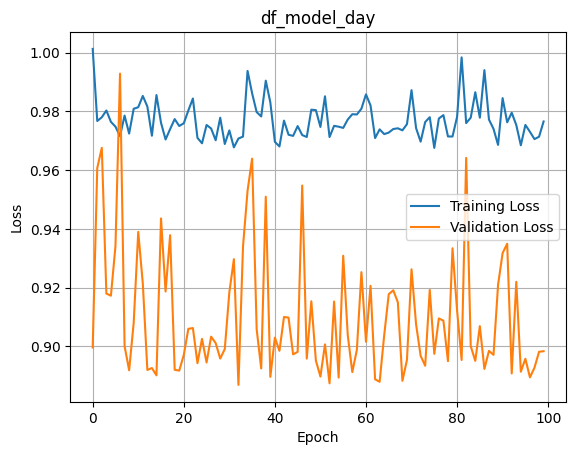

In [579]:
plot_loss(history, title="df_model_day")

In [580]:
# double check using -> evaluate_model function
evaluate_model(df_model_day, X_test, y_test)

16/16 [==============================] - 0s 2ms/step
Mean Absolute Error (MAE): 0.7775897682194522
Mean Squared Error (MSE): 0.9179524122927394
Root Mean Squared Error (RMSE): 0.9580983312232306
---------------------------------------------------------
     Actual  Predicted  Difference
0  0.667346   0.192054   -0.475292
1 -1.176891  -0.342594    0.834296
2  0.657377   0.192054   -0.465323
3 -1.077202  -0.342594    0.734608
4 -0.130162  -0.342594   -0.212432
5  1.514698  -0.075270   -1.589968
6  1.405041  -0.208932   -1.613973
7 -0.229850   0.325716    0.555566
8  0.727159  -0.342594   -1.069753
9  0.677315   0.192054   -0.485261
---------------------------------------------------------


(0.7775897682194522, 0.9179524122927394, 0.9580983312232306)

In [581]:
# View count of predictions which were close to actual values
compare_predictions_with_actual(df_model_day, X_test, y_test)

16/16 [==============================] - 0s 7ms/step
Total predicitions: --  511
Number of Predicitions within 0.1: --  38
Number of Predicitions within 0.05: --  18
---------------------------------------------------------
Percentage of predictions within [0.1]: -- 7.44%
Percentage of predictions within [0.05]: -- 3.52%


16/16 [==============================] - 0s 3ms/step


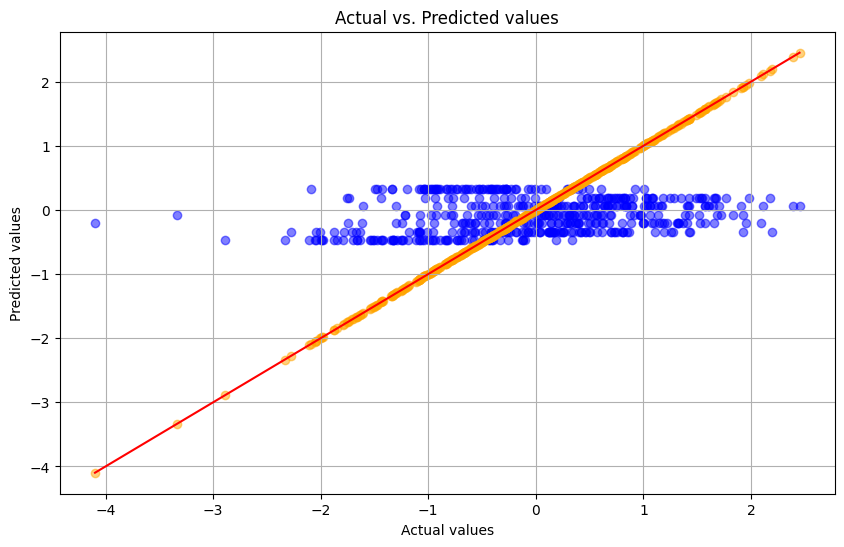

In [582]:
#display plot - df_model -- simple regression [day]
plot_predictions(df_model_day, X_test, y_test)

16/16 [==============================] - 0s 4ms/step


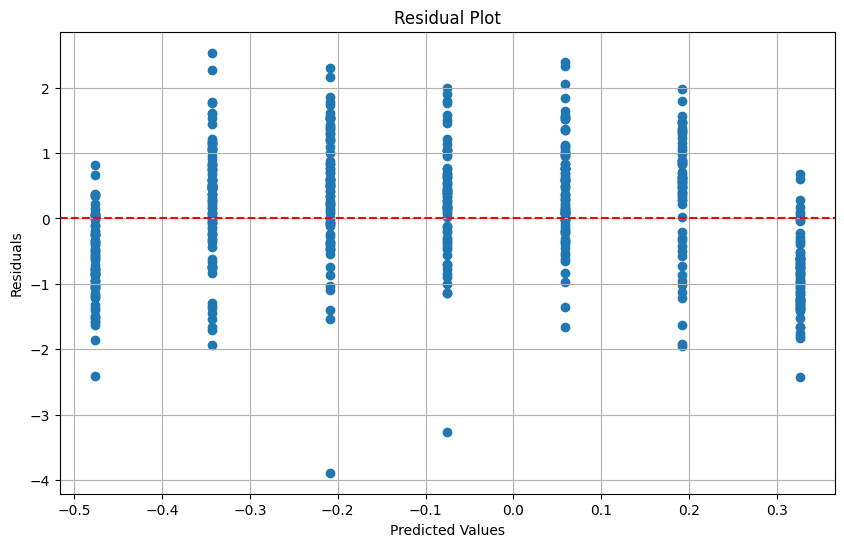

In [583]:
# View residuals - distance
plot_residuals(df_model_day, X_test, y_test)

Day vs. Number of collisions does seem to have a similar trend from assessment01 analysis. Typically, Thursday and Friday have the highest average. In this case, Thursday is the highest average, compared to the a1 assessment, where Friday was the highest average.

### Multi-Linear Regression

In [584]:
# Preparing the data
X = df_copy[['day', 'temp', 'visib', 'wdsp', 'fog']].values  # Convert to numpy array
y = df_copy['NUM_COLLISIONS'].values  # Target variable

In [585]:
# Splitting the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Normalization layer and adapt it to the training data
normaliser = tf.keras.layers.Normalization(axis=-1)  # Normalize each feature independently
normaliser.adapt(X_train)  # Compute the mean and variance to be used for later scaling

# Building the model
df_model = tf.keras.Sequential([
    normaliser,
    tf.keras.layers.Dense(1, input_shape=(5,))  # 5 features as input, 1 unit for output (linear output)
])

# View Summary
df_model.summary()

# Compiling the model
# adam -> learning rate [default] = 0.001
df_model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error', metrics=['mean_squared_error'])

# Training the model
# verbose = 0 [does not show the fit process]. changing this to verbose=1 will show the process.
history = df_model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0)  # Training for 100 epochs

# Evaluating the model
mse = df_model.evaluate(X_test, y_test)

# Print results
print("Test -- Mean Standard Errors:", mse)

Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_29 (Normaliz  (None, 5)                 11        
 ation)                                                          
                                                                 
 dense_134 (Dense)           (None, 1)                 6         
                                                                 
Total params: 17 (72.00 Byte)
Trainable params: 6 (24.00 Byte)
Non-trainable params: 11 (48.00 Byte)
_________________________________________________________________
16/16 [==============================] - 0s 2ms/step - loss: 0.9405 - mean_squared_error: 0.9405
Test -- Mean Standard Errors: [0.9405081868171692, 0.9405081868171692]


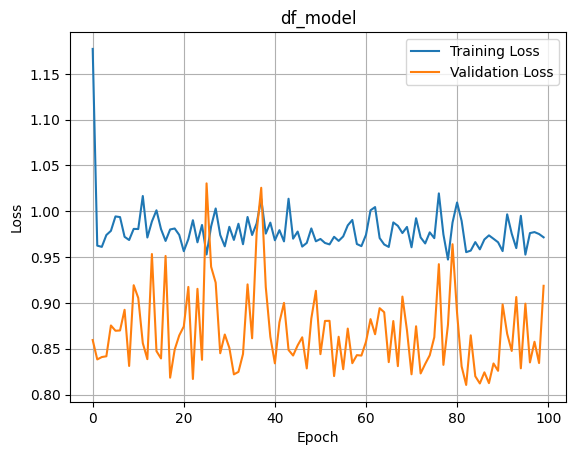

In [586]:
# plot the loss, val_loss results from model.fit() -> history
plot_loss(history, title="df_model")

In [587]:
# double check using -> evaluate_model function
evaluate_model(df_model, X_test, y_test)

16/16 [==============================] - 0s 1ms/step
Mean Absolute Error (MAE): 0.763876885321591
Mean Squared Error (MSE): 0.9405080524980927
Root Mean Squared Error (RMSE): 0.9697979441605827
---------------------------------------------------------
     Actual  Predicted  Difference
0  0.667346   0.350323   -0.317023
1 -1.176891  -0.642421    0.534470
2  0.657377   0.562290   -0.095087
3 -1.077202  -0.857199    0.220003
4 -0.130162  -0.334457   -0.204296
5  1.514698   0.333775   -1.180923
6  1.405041   0.114411   -1.290630
7 -0.229850   0.926383    1.156233
8  0.727159   0.033598   -0.693561
9  0.677315   0.065844   -0.611471
---------------------------------------------------------


(0.763876885321591, 0.9405080524980927, 0.9697979441605827)

In [588]:
# View count of predictions which were close to actual values
compare_predictions_with_actual(df_model, X_test, y_test)

16/16 [==============================] - 0s 2ms/step
Total predicitions: --  511
Number of Predicitions within 0.1: --  44
Number of Predicitions within 0.05: --  20
---------------------------------------------------------
Percentage of predictions within [0.1]: -- 8.61%
Percentage of predictions within [0.05]: -- 3.91%


16/16 [==============================] - 0s 2ms/step


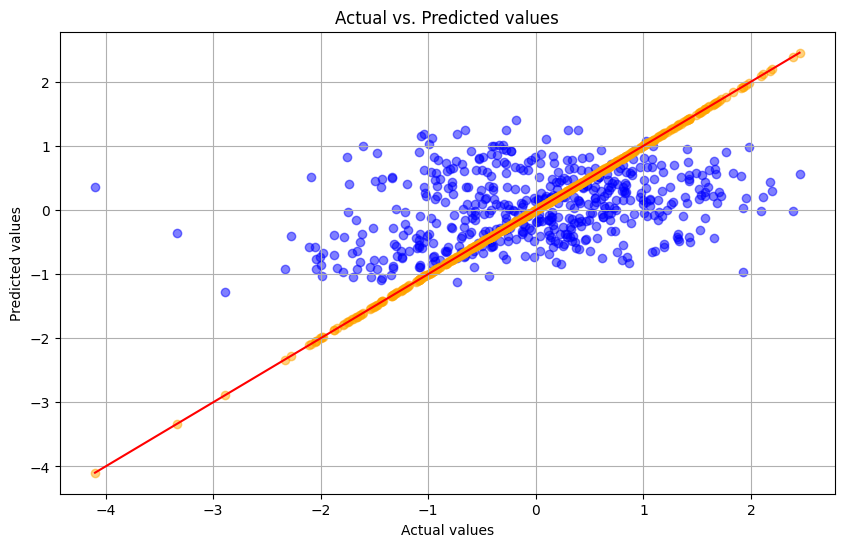

In [589]:
#display plot - df-model
plot_predictions(df_model, X_test, y_test)

16/16 [==============================] - 0s 2ms/step


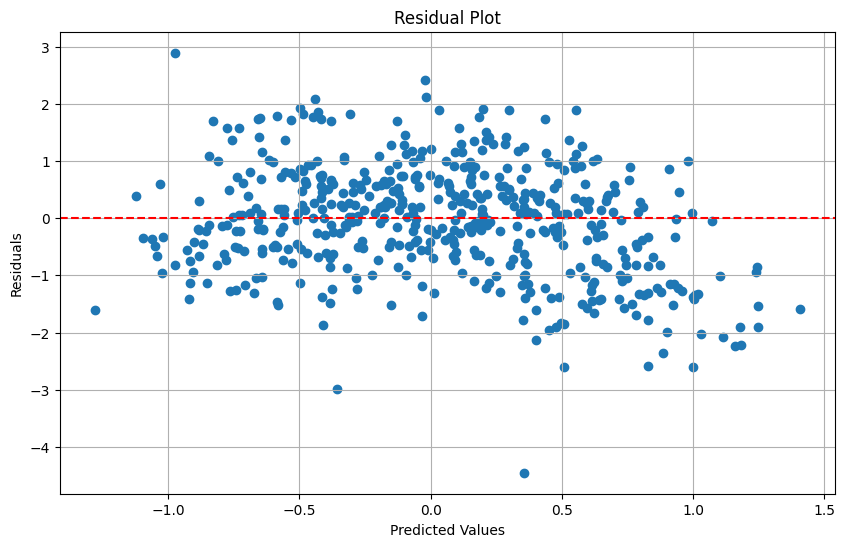

In [590]:
# View residuals - distance
plot_residuals(df_model, X_test, y_test)

The predicition plot display the test values (orange) vs. predictions (blue) made by the model.

df_model uses a learning rate (lr) of 0.1.

The plot_loss graph shows a fair amount of fluctuating between loss and valdiation loss.

This might relate to a couple of reasons:
- The model might be experiencing high variance and needs to generalize beyond the training data (overfitting).

- The learning rate might need to be lowered, causing the model to overshoot optimal weights during optimization.

Therefore, testing another model with different learning rates might produce a better outcome for models going forward.

In [591]:
# model 2 -- learning rate changed. [lr = 0.01]

# Building the model
df_model2 = tf.keras.Sequential([
    normaliser,
    tf.keras.layers.Dense(1, input_shape=(5,))  # 5 features as input, 1 unit for output (linear output)
])

# View Summary
df_model2.summary()

# Compiling the model
# adam -> learning rate [default] = 0.001
df_model2.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['mean_squared_error'])

# Training the model
# verbose = 0 [does not show the fit process]. changing this to verbose=1 will show the process.
history = df_model2.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0)  # Training for 50 epochs

# Evaluating the model
mse = df_model2.evaluate(X_test, y_test)

# Print results
print("Test -- Mean Standard Errors:", mse)

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_29 (Normaliz  (None, 5)                 11        
 ation)                                                          
                                                                 
 dense_135 (Dense)           (None, 1)                 6         
                                                                 
Total params: 17 (72.00 Byte)
Trainable params: 6 (24.00 Byte)
Non-trainable params: 11 (48.00 Byte)
_________________________________________________________________
16/16 [==============================] - 0s 2ms/step - loss: 0.8706 - mean_squared_error: 0.8706
Test -- Mean Standard Errors: [0.8706440329551697, 0.8706440329551697]


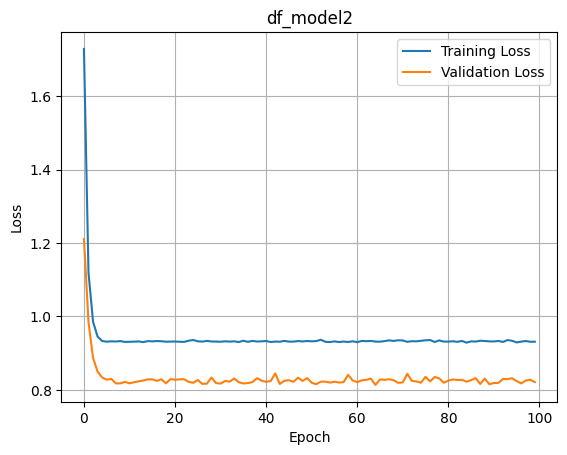

In [592]:
# plot the loss, val_loss results from model.fit() -> history
plot_loss(history, title="df_model2")

In [593]:
# double check using -> evaluate_model function
evaluate_model(df_model2, X_test, y_test)

16/16 [==============================] - 0s 2ms/step
Mean Absolute Error (MAE): 0.7477000758026524
Mean Squared Error (MSE): 0.8706440645025122
Root Mean Squared Error (RMSE): 0.9330830962473343
---------------------------------------------------------
     Actual  Predicted  Difference
0  0.667346   0.112967   -0.554379
1 -1.176891  -0.415546    0.761344
2  0.657377   0.398299   -0.259079
3 -1.077202  -0.599492    0.477710
4 -0.130162  -0.175680   -0.045518
5  1.514698   0.094148   -1.420550
6  1.405041   0.054523   -1.350518
7 -0.229850   0.367980    0.597830
8  0.727159  -0.156684   -0.883843
9  0.677315  -0.180514   -0.857829
---------------------------------------------------------


(0.7477000758026524, 0.8706440645025122, 0.9330830962473343)

In [594]:
# View count of predictions which were close to actual values
compare_predictions_with_actual(df_model2, X_test, y_test)

16/16 [==============================] - 0s 2ms/step
Total predicitions: --  511
Number of Predicitions within 0.1: --  48
Number of Predicitions within 0.05: --  24
---------------------------------------------------------
Percentage of predictions within [0.1]: -- 9.39%
Percentage of predictions within [0.05]: -- 4.70%


16/16 [==============================] - 0s 2ms/step


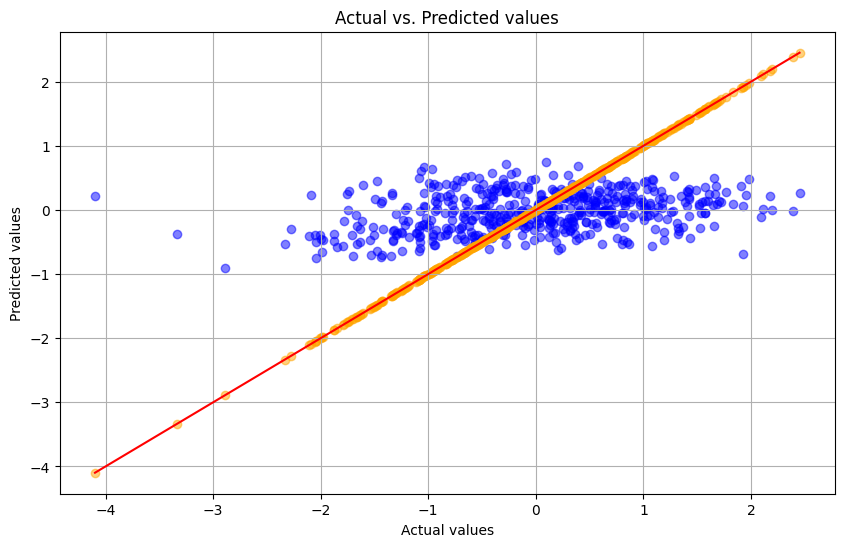

In [595]:
#display plot - df_model 2
plot_predictions(df_model2, X_test, y_test)

Viewing results based on the plot_predictions, the models perform very similarly.

16/16 [==============================] - 0s 2ms/step


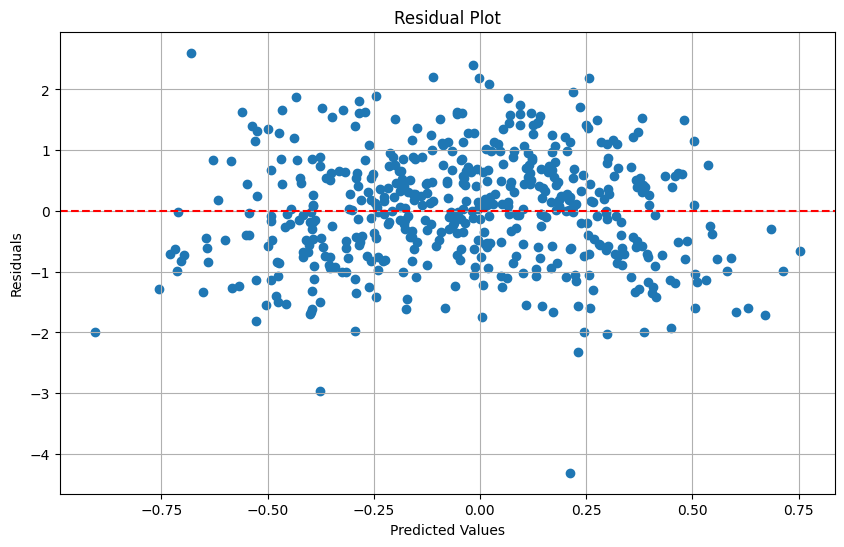

In [596]:
# View residuals - distance
plot_residuals(df_model2, X_test, y_test)

In [597]:
# model 3 -- learning rate changed. [0.001] (DEFAULT)

# Building the model
df_model3 = tf.keras.Sequential([
    normaliser,
    tf.keras.layers.Dense(1, input_shape=(5,))  # 5 features as input, 1 unit for output (linear output)
])

# View Summary
df_model3.summary()

# Compiling the model
# adam -> learning rate [default] = 0.001
df_model3.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error'])

# Training the model
# verbose = 0 [does not show the fit process]. changing this to verbose=1 will show the process.
history = df_model3.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0)  # Training for 50 epochs

# Evaluating the model
mse = df_model3.evaluate(X_test, y_test)

# Print results
print("Test -- Mean Standard Errors:", mse)

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_29 (Normaliz  (None, 5)                 11        
 ation)                                                          
                                                                 
 dense_136 (Dense)           (None, 1)                 6         
                                                                 
Total params: 17 (72.00 Byte)
Trainable params: 6 (24.00 Byte)
Non-trainable params: 11 (48.00 Byte)
_________________________________________________________________
16/16 [==============================] - 0s 2ms/step - loss: 0.8627 - mean_squared_error: 0.8627
Test -- Mean Standard Errors: [0.8627462387084961, 0.8627462387084961]


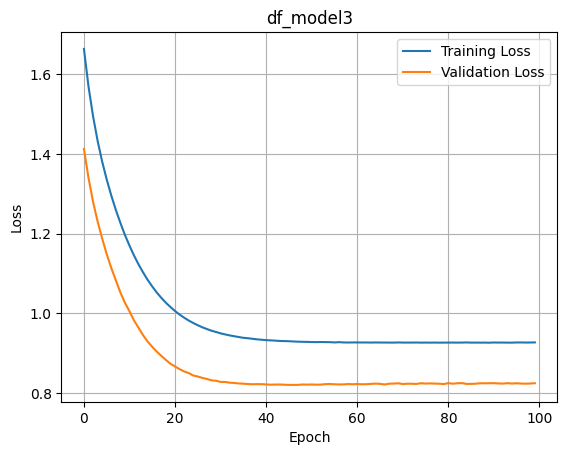

In [598]:
# plot the loss, val_loss results from model.fit() -> history
plot_loss(history, title="df_model3")

In [599]:
# double check using -> evaluate_model function
evaluate_model(df_model3, X_test, y_test)

16/16 [==============================] - 0s 2ms/step
Mean Absolute Error (MAE): 0.7445446551973259
Mean Squared Error (MSE): 0.8627462427246094
Root Mean Squared Error (RMSE): 0.9288413442157974
---------------------------------------------------------
     Actual  Predicted  Difference
0  0.667346   0.129451   -0.537895
1 -1.176891  -0.413721    0.763169
2  0.657377   0.406789   -0.250588
3 -1.077202  -0.584947    0.492255
4 -0.130162  -0.110658    0.019503
5  1.514698   0.151107   -1.363591
6  1.405041   0.107049   -1.297992
7 -0.229850   0.392617    0.622467
8  0.727159  -0.106367   -0.833526
9  0.677315  -0.111828   -0.789143
---------------------------------------------------------


(0.7445446551973259, 0.8627462427246094, 0.9288413442157974)

In [600]:
# View count of predictions which were close to actual values
compare_predictions_with_actual(df_model3, X_test, y_test)

16/16 [==============================] - 0s 1ms/step
Total predicitions: --  511
Number of Predicitions within 0.1: --  42
Number of Predicitions within 0.05: --  27
---------------------------------------------------------
Percentage of predictions within [0.1]: -- 8.22%
Percentage of predictions within [0.05]: -- 5.28%


16/16 [==============================] - 0s 2ms/step


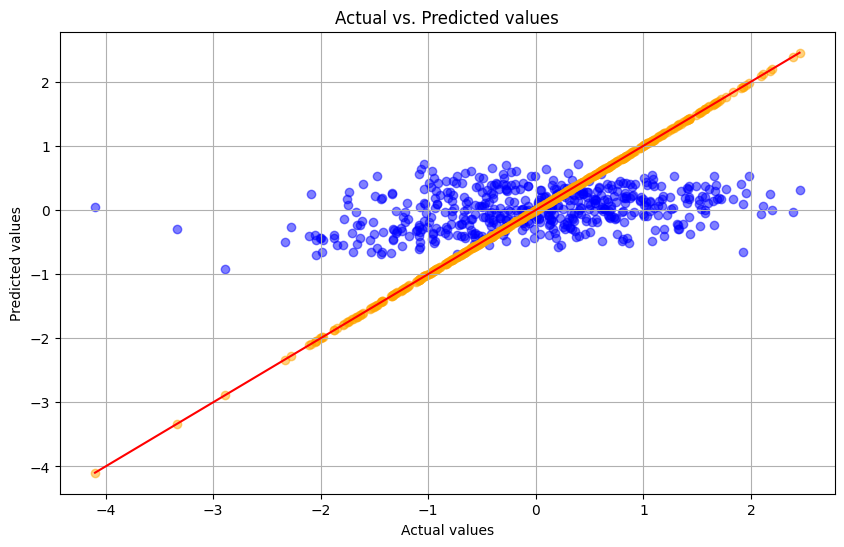

In [601]:
#display plot - df_model 3
plot_predictions(df_model3, X_test, y_test)

16/16 [==============================] - 0s 1ms/step


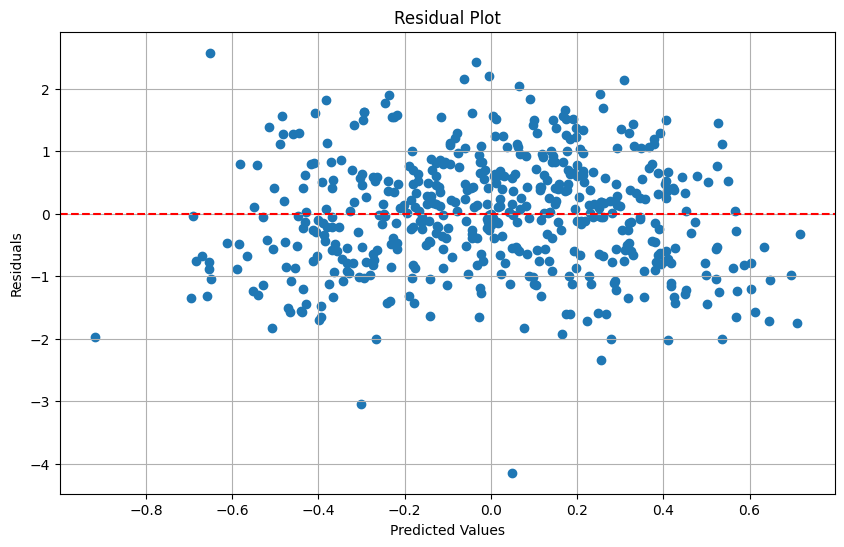

In [602]:
# View residuals - distance
plot_residuals(df_model3, X_test, y_test)

Best Learning Rate: [df_models]:

The model with a learning rate of 0.01 strikes the best balance between convergence speed and stability, and the closeness of the training and validation loss suggests that it is generalizing well without overfitting (Chugh, 2022).

The next models will use the same LR.

## SkLearn - Model

Resource: Sklearn.LinearRegression() [LinearRegression()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score)

In [603]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Preparing the data
X = df_copy[['day', 'temp', 'visib', 'wdsp', 'fog']]  # Features
y = df_copy['NUM_COLLISIONS']  # Target variable

# Splitting the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building the Linear Regression model
sk_model = LinearRegression()

# Training the model
sk_model.fit(X_train, y_train)

# Predicting the target for test dataset
y_pred = sk_model.predict(X_test)

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Absolute Error: 0.743604259904296
Mean Squared Error: 0.861372217552266
R-squared: 0.10378220796122783


In [604]:
# Return the r2 (R-Sqaured )
acc = sk_model.score(X_train, y_train)
acc # accuracy

0.10377445503987559

This is relatively low considering the max R2 value range is between 0 and 1, which can be represented as a percentage, where 1 equals 100% (IBM, 2024).

Here R2 = 10%

In [605]:
print(f"Coefficents: {sk_model.coef_}, Intercept: {sk_model.intercept_}")

Coefficents: [0.12311552 0.01502238 0.00229545 0.01965081 0.05000837], Intercept: -1.502983021648895


positive coefficients [0.123, 0.015, 0.002, 0.019, 0.050]

Indicate the target variable's increase per unit rise in features, with the first feature being the most influential ['day'].

The intercept at -1.502983021648895 denotes the predicted base value when feature values are zero.

(Benton, 2020; Bobbitt, 2021)

In [606]:
# double check using -> evaluate_model function
evaluate_model(sk_model, X_test, y_test)

Mean Absolute Error (MAE): 0.743604259904296
Mean Squared Error (MSE): 0.861372217552266
Root Mean Squared Error (RMSE): 0.9281014047787375
---------------------------------------------------------
        Actual  Predicted  Difference
57    0.667346   0.087079   -0.580267
195  -1.176891  -0.419125    0.757766
2227  0.657377   0.397806   -0.259571
234  -1.077202  -0.612935    0.464267
1903 -0.130162  -0.099331    0.030831
1212  1.514698   0.146716   -1.367982
1895  1.405041   0.122507   -1.282533
790  -0.229850   0.382280    0.612131
1747  0.727159  -0.062623   -0.789782
174   0.677315  -0.195405   -0.872720
---------------------------------------------------------


(0.743604259904296, 0.861372217552266, 0.9281014047787375)

In [607]:
# View count of predictions which were close to actual values
compare_predictions_with_actual(sk_model, X_test, y_test)

Total predicitions: --  511
Number of Predicitions within 0.1: --  42
Number of Predicitions within 0.05: --  21
---------------------------------------------------------
Percentage of predictions within [0.1]: -- 8.22%
Percentage of predictions within [0.05]: -- 4.11%


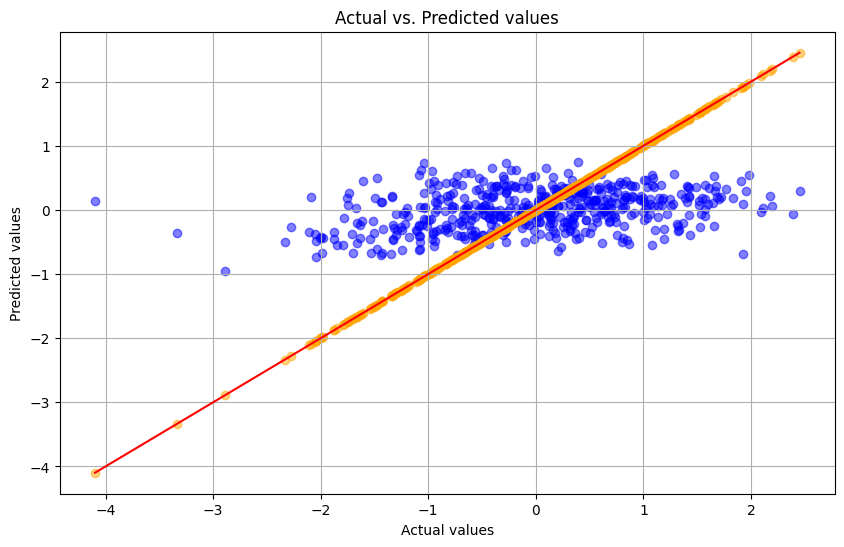

In [608]:
# view - sklearn model - predict
plot_predictions(sk_model, X_test, y_test)

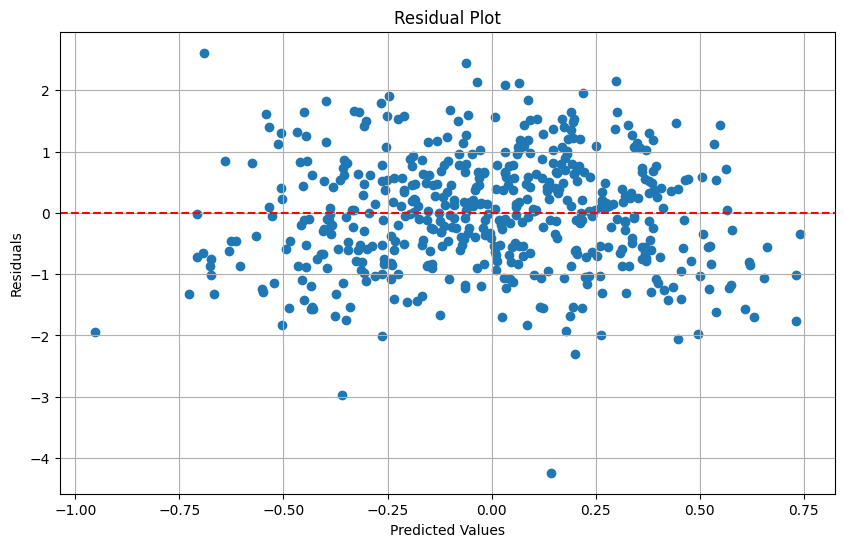

In [609]:
# View residuals - distance
plot_residuals(sk_model, X_test, y_test)

Not much changed between using the sklearn's built-in LinearRegression() function. [used for testing]

# Linear Regression - [df2] - full set

Build and Train, then evaluate on the full set loaded in.

In [610]:
# Create a copy of dataFrame
df2_copy = df2.copy()

In [611]:
# Check data - head()
df2_copy.head(10)

,day,mo,temp,dewp,slp,visib,wdsp,mxpsd,gust,max,min,prcp,fog,NUM_COLLISIONS
1,3,1,14.7,2.0,1024.9,10.0,12.9,20.0,31.1,18.0,5.0,0.00,0,0.547720
2,2,1,9.5,-0.5,1022.2,10.0,15.0,18.1,25.1,21.0,5.0,0.00,0,-1.456018
3,6,1,14.8,-0.5,1022.4,10.0,11.8,15.9,22.9,23.0,9.0,0.00,0,1.056131
4,4,1,22.6,10.2,1011.8,9.4,12.1,26.0,35.9,27.0,17.1,0.00,0,-0.608666
5,7,1,13.2,-0.2,1013.5,10.0,22.4,28.0,39.0,27.0,10.9,0.00,0,-0.000567
6,5,1,13.1,-2.4,1022.7,9.9,14.8,21.0,29.9,27.0,6.1,0.00,0,-0.259757
7,4,1,20.3,10.4,1021.2,6.3,8.1,14.0,18.2,27.0,17.1,0.02,0,0.497876
8,5,1,22.0,5.8,1027.2,10.0,8.1,15.9,24.1,27.0,12.9,0.01,0,0.577626
9,2,1,18.3,5.7,1035.5,10.0,11.0,18.1,22.9,28.0,15.1,0.00,0,0.697253
10,3,1,20.8,5.2,1025.2,8.8,10.3,21.0,31.1,28.0,19.0,0.00,0,1.773888


In [612]:
# Preparing the data
X = df2_copy[['day', 'mo', 'temp', 'dewp', 'slp', 'visib', 'wdsp', 'mxpsd', 'gust', 'max', 'min', 'prcp', 'fog']].values  # Features : Convert to numpy array
y = df2_copy['NUM_COLLISIONS'].values  # Target variable

print(X) # Features
print(y) # Number of collisions

X.shape

[[ 3.    1.   14.7  ...  5.    0.    0.  ]
 [ 2.    1.    9.5  ...  5.    0.    0.  ]
 [ 6.    1.   14.8  ...  9.    0.    0.  ]
 ...
 [ 7.   12.   45.6  ... 26.1   0.17  1.  ]
 [ 3.   12.   39.7  ... 35.1   0.83  0.  ]
 [ 1.   12.   46.   ... 33.1   0.05  1.  ]]
[ 0.54771994 -1.45601827  1.05613113 ... -0.33950743  0.30846762
 -0.40928935]


(2551, 13)

In [613]:
# Splitting the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Normalization layer and adapt it to the training data
normaliser = tf.keras.layers.Normalization(axis=-1)  # Normalize each feature independently
normaliser.adapt(X_train)  # Compute the mean and variance to be used for later scaling

# Building the model
df2_model_full = tf.keras.Sequential([
    normaliser,
    tf.keras.layers.Dense(1, input_shape=(13,))  # 13 features as input, 1 unit for output (linear output)
])

# View Summary
df2_model_full.summary()

# Compiling the model
# adam -> learning rate [default] = 0.001
df2_model_full.compile(optimizer = tf.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error', metrics=['mean_squared_error'])

# Training the model
# verbose = 0 [does not show the fit process]. changing this to verbose=1 will show the process.
history = df2_model_full.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0)  # Training for 100 epochs

# Evaluating the model
mse = df2_model_full.evaluate(X_test, y_test)

# Print results
print("Test -- Mean Standard Errors:", mse)

Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_30 (Normaliz  (None, 13)                27        
 ation)                                                          
                                                                 
 dense_137 (Dense)           (None, 1)                 14        
                                                                 
Total params: 41 (168.00 Byte)
Trainable params: 14 (56.00 Byte)
Non-trainable params: 27 (112.00 Byte)
_________________________________________________________________
16/16 [==============================] - 0s 2ms/step - loss: 0.9195 - mean_squared_error: 0.9195
Test -- Mean Standard Errors: [0.9194628596305847, 0.9194628596305847]


testing learning_rate on a larger dataset [lr = 0.1]

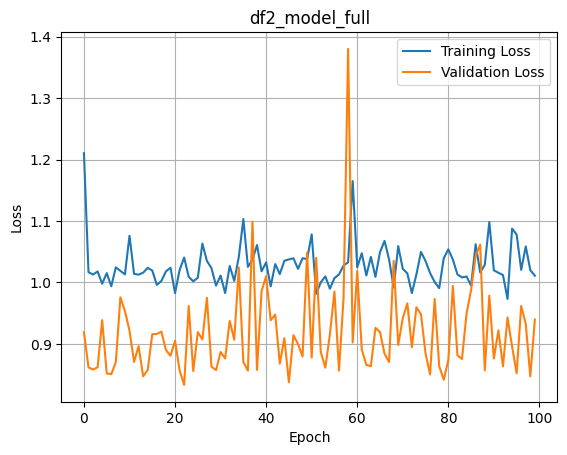

In [614]:
# plot the loss, val_loss results from model.fit() -> history
plot_loss(history, title="df2_model_full")

The plot_loss results - show the model overfitting during the fit() [training].

Compared to the df_model [less variables] - this version has extreme overfitting results.

Therefore, another model [version 2] will use the lr = 0.01 [best fit]

In [615]:
# double check using -> evaluate_model function
evaluate_model(df2_model_full, X_test, y_test)

16/16 [==============================] - 0s 2ms/step
Mean Absolute Error (MAE): 0.7660892798375102
Mean Squared Error (MSE): 0.9194628422097798
Root Mean Squared Error (RMSE): 0.9588862509233198
---------------------------------------------------------
     Actual  Predicted  Difference
0  0.667346  -0.356124   -1.023470
1 -1.176891  -1.140489    0.036402
2  0.657377   0.392331   -0.265046
3 -1.077202  -0.880970    0.196233
4 -0.130162   0.292976    0.423137
5  1.514698   0.113942   -1.400756
6  1.405041   0.228462   -1.176579
7 -0.229850   0.464315    0.694166
8  0.727159   0.377111   -0.350048
9  0.677315   0.061987   -0.615328
---------------------------------------------------------


(0.7660892798375102, 0.9194628422097798, 0.9588862509233198)

In [616]:
# View count of predictions which were close to actual values
compare_predictions_with_actual(df2_model_full, X_test, y_test)

16/16 [==============================] - 0s 2ms/step
Total predicitions: --  511
Number of Predicitions within 0.1: --  37
Number of Predicitions within 0.05: --  22
---------------------------------------------------------
Percentage of predictions within [0.1]: -- 7.24%
Percentage of predictions within [0.05]: -- 4.31%


16/16 [==============================] - 0s 2ms/step


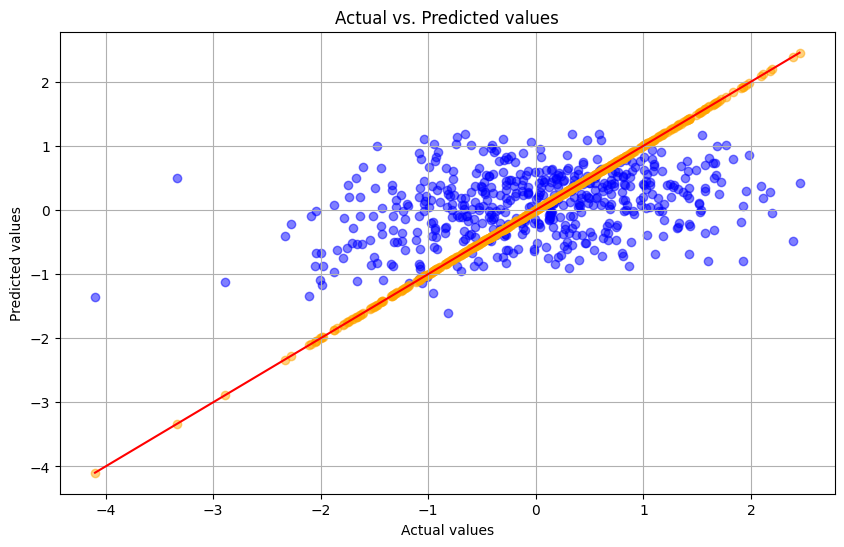

In [617]:
# view - sklearn model - predict
plot_predictions(df2_model_full, X_test, y_test)

16/16 [==============================] - 0s 2ms/step


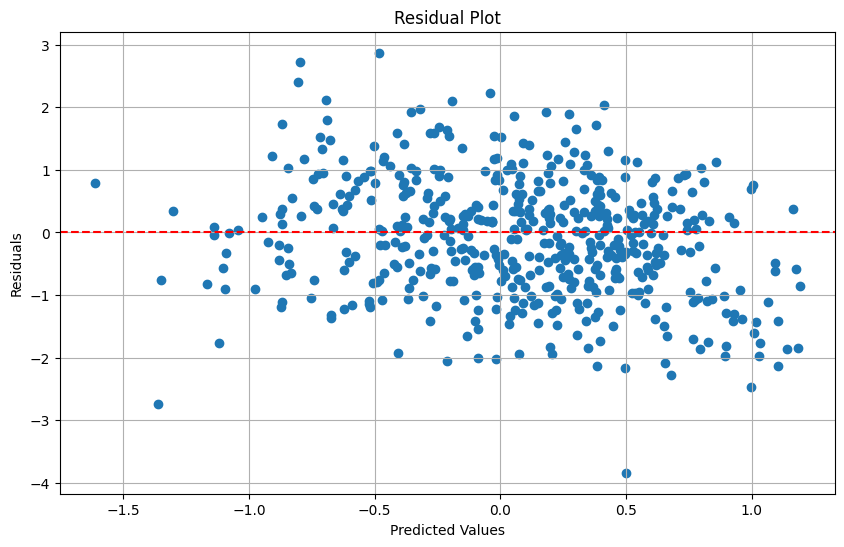

In [618]:
# View residuals - distance
plot_residuals(df2_model_full, X_test, y_test)

In [619]:
# testing learning_rate -> 0.01 [best fit in df_model]

# Building the model
df2_model_full_v2 = tf.keras.Sequential([
    normaliser,
    tf.keras.layers.Dense(1, input_shape=(13,))  # 13 features as input, 1 unit for output (linear output)
])

# View summary
df2_model_full_v2.summary()

# Compiling the model
# adam -> learning rate [default] = 0.001
df2_model_full_v2.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['mean_squared_error'])

# Training the model
# verbose = 0 [does not show the fit process]. changing this to verbose=1 will show the process.
history = df2_model_full_v2.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0)  # Training for 100 epochs

# Evaluating the model
mse = df2_model_full_v2.evaluate(X_test, y_test)

# Print results
print("Test -- Mean Standard Errors:", mse)

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_30 (Normaliz  (None, 13)                27        
 ation)                                                          
                                                                 
 dense_138 (Dense)           (None, 1)                 14        
                                                                 
Total params: 41 (168.00 Byte)
Trainable params: 14 (56.00 Byte)
Non-trainable params: 27 (112.00 Byte)
_________________________________________________________________
16/16 [==============================] - 0s 3ms/step - loss: 0.8818 - mean_squared_error: 0.8818
Test -- Mean Standard Errors: [0.8817542195320129, 0.8817542195320129]


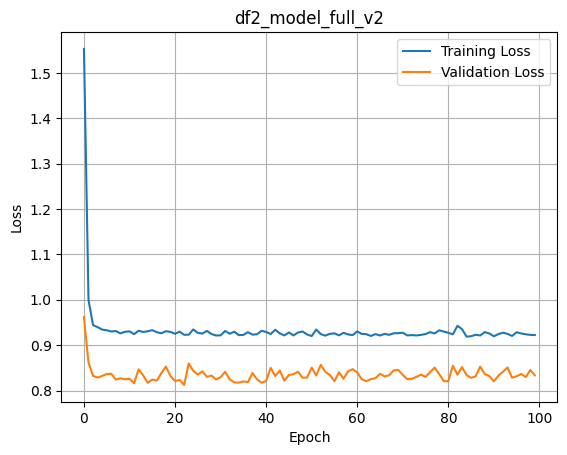

In [620]:
# plot the loss, val_loss results from model.fit() -> history
plot_loss(history, title="df2_model_full_v2")

In [621]:
# double check using -> evaluate_model function
evaluate_model(df2_model_full_v2, X_test, y_test)

16/16 [==============================] - 0s 5ms/step
Mean Absolute Error (MAE): 0.7508785485175934
Mean Squared Error (MSE): 0.8817541598038836
Root Mean Squared Error (RMSE): 0.9390176568115658
---------------------------------------------------------
     Actual  Predicted  Difference
0  0.667346   0.043089   -0.624257
1 -1.176891  -0.421050    0.755841
2  0.657377   0.414690   -0.242687
3 -1.077202  -0.466697    0.610505
4 -0.130162  -0.139558   -0.009396
5  1.514698  -0.036569   -1.551267
6  1.405041  -0.033185   -1.438226
7 -0.229850   0.382550    0.612400
8  0.727159  -0.075338   -0.802498
9  0.677315  -0.112900   -0.790215
---------------------------------------------------------


(0.7508785485175934, 0.8817541598038836, 0.9390176568115658)

In [622]:
# View count of predictions which were close to actual values
compare_predictions_with_actual(df2_model_full_v2, X_test, y_test)

16/16 [==============================] - 0s 3ms/step
Total predicitions: --  511
Number of Predicitions within 0.1: --  49
Number of Predicitions within 0.05: --  27
---------------------------------------------------------
Percentage of predictions within [0.1]: -- 9.59%
Percentage of predictions within [0.05]: -- 5.28%


16/16 [==============================] - 0s 3ms/step


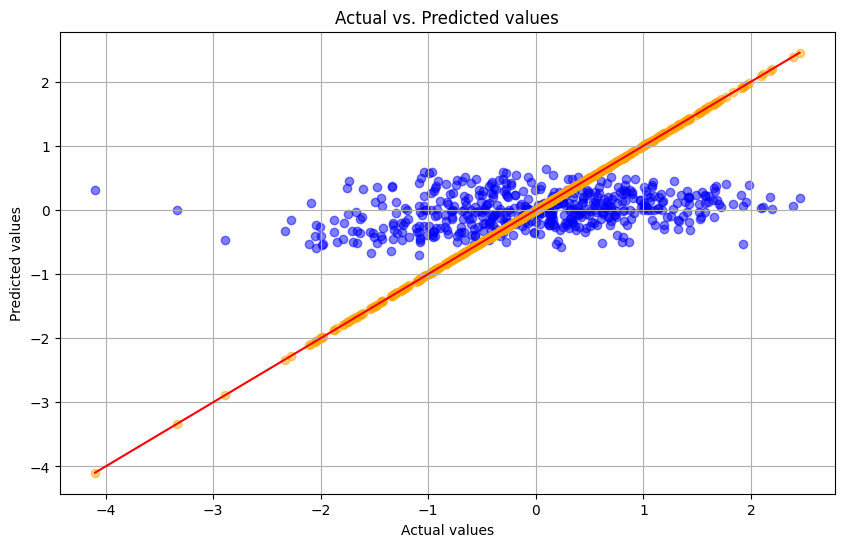

In [623]:
# view - df2_model [VERSION 2] - predict
plot_predictions(df2_model_full_v2, X_test, y_test)

16/16 [==============================] - 0s 2ms/step


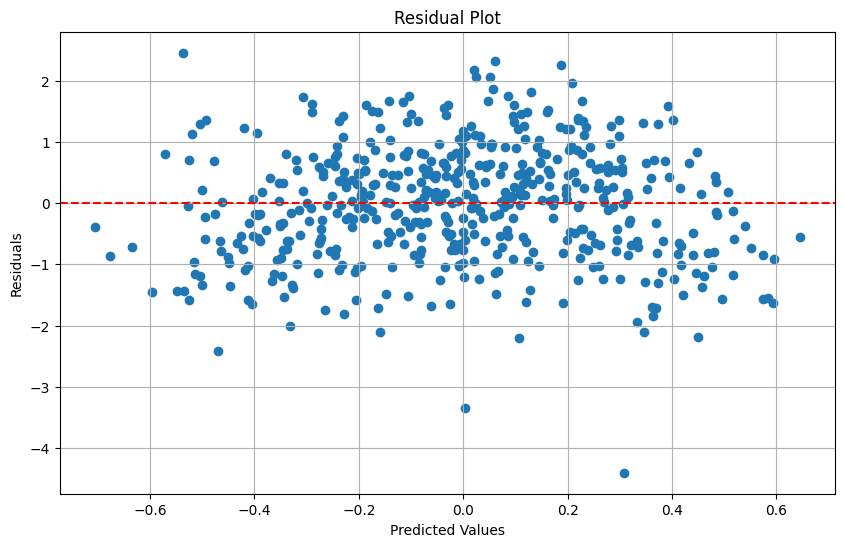

In [624]:
# View residuals - distance
plot_residuals(df2_model_full_v2, X_test, y_test)

df2_model [v1]:

- Mean Absolute Error (MAE): 0.7634371961938896
- Mean Squared Error (MSE): 0.921979960524768
- Root Mean Squared Error (RMSE): 0.9601978757135261

---

df2_model_v2:

- Mean Absolute Error (MAE): 0.7413901228033738
- Mean Squared Error (MSE): 0.8646155040410844
- Root Mean Squared Error (RMSE): 0.9298470326032581

# Overall Summary [Linear Regression]

**Models:**

df_model_day

- Mean Absolute Error (MAE): 0.7706522858948416
- Mean Squared Error (MSE): 0.9126066263065944
- Root Mean Squared Error (RMSE): 0.9553044678565019

Learning Rates Tested:

1.   df_model [v1] (LR = 0.1)

- Mean Absolute Error (MAE): 0.750161557764069
- Mean Squared Error (MSE): 0.8723097550393301
- Root Mean Squared Error (RMSE): 0.9339752432689691

2.   df_model2 [v2] (LR = 0.01)

- Mean Absolute Error (MAE): 0.7420508015461734
- Mean Squared Error (MSE): 0.8565974730003774
- Root Mean Squared Error (RMSE): 0.9255255118041735

3.   df_model3 [v3] (LR = 0.001)

- Mean Absolute Error (MAE): 0.7711064587516919
- Mean Squared Error (MSE): 0.9138101106375907
- Root Mean Squared Error (RMSE): 0.9559341560157743

4. sk_model

- Mean Absolute Error (MAE): 0.743604259904296
- Mean Squared Error (MSE): 0.861372217552266
- Root Mean Squared Error (RMSE): 0.9281014047787375

---

Full set vs. Selected set

[FULL]
- Mean Absolute Error (MAE): 0.7413901228033738
- Mean Squared Error (MSE): 0.8646155040410844
- Root Mean Squared Error (RMSE): 0.9298470326032581

[SELECTED]
- Mean Absolute Error (MAE): 0.7420508015461734
- Mean Squared Error (MSE): 0.8565974730003774
- Root Mean Squared Error (RMSE): 0.9255255118041735

---

Results:

df_model2 (lr = 0.01) - has a slightly better performance in terms of loss metrics.

df2_model2 [full] - has best score in terms of MAE [0.001 margin]

All predictions plotted tended to follow a very similar pattern, which can be concluded that it has not performed with the best accuracy in predictions overall.



In [625]:
df_copy.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
day,2551.0,3.997256e+00,2.000880,1.000000,2.000000,4.00000,6.000000,7.000000
temp,2551.0,5.147236e+01,14.165027,5.800000,40.400000,52.00000,63.900000,77.500000
visib,2551.0,8.295374e+00,2.209467,0.200000,7.100000,9.40000,10.000000,10.000000
wdsp,2551.0,1.068914e+01,4.243511,2.700000,7.700000,10.10000,13.000000,39.300000
fog,2551.0,2.524500e-01,0.434503,0.000000,0.000000,0.00000,1.000000,1.000000
NUM_COLLISIONS,2551.0,-2.785350e-16,1.000000,-4.097763,-0.678448,0.02934,0.657377,5.601925


Based on NUM_COLLISIONS scale - the errors being between 0.7 and 0.9 indicate less accuracy.

If the scale for number of collisions ranged from 100 to 1000 then the error margin of these ranges would be considered very good.

# Deep Neutral Network (DNN)

In [626]:
# load dnn model _ raw github data
dnn = pd.read_csv("https://raw.githubusercontent.com/LeeaDevine/12005304uhi_DataAnalytics/main/Assessment01/dnn_data1.csv",  index_col=0)

In [627]:
# Check columns
dnn.columns

Index(['Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov',
       'Oct', 'Sep', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', 'year',
       'temp', 'visib', 'wdsp', 'fog', 'NUM_COLLISIONS'],
      dtype='object')

In [628]:
# head() -> check data
dnn.head(10)

,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,...,Sun,Thu,Tue,Wed,year,temp,visib,wdsp,fog,NUM_COLLISIONS
1,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,2018,14.7,10.0,12.9,0,0.547720
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,2018,9.5,10.0,15.0,0,-1.456018
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,2014,14.8,10.0,11.8,0,1.056131
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,2015,22.6,9.4,12.1,0,-0.608666
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,2018,13.2,10.0,22.4,0,-0.000567
6,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,2015,13.1,9.9,14.8,0,-0.259757
7,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,2014,20.3,6.3,8.1,0,0.497876
8,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,2014,22.0,10.0,8.1,0,0.577626
9,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,2017,18.3,10.0,11.0,0,0.697253
10,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,2015,20.8,8.8,10.3,0,1.773888


In [629]:
# Check mean, std, other stats -> summary of data
dnn.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Apr,2551.0,8.232066e-02,0.274907,0.000000,0.000000,0.00000,0.000000,1.000000
Aug,2551.0,8.506468e-02,0.279033,0.000000,0.000000,0.00000,0.000000,1.000000
Dec,2551.0,8.467268e-02,0.278449,0.000000,0.000000,0.00000,0.000000,1.000000
Feb,2551.0,7.722462e-02,0.267000,0.000000,0.000000,0.00000,0.000000,1.000000
Jan,2551.0,8.506468e-02,0.279033,0.000000,0.000000,0.00000,0.000000,1.000000
Jul,2551.0,8.467268e-02,0.278449,0.000000,0.000000,0.00000,0.000000,1.000000
Jun,2551.0,8.232066e-02,0.274907,0.000000,0.000000,0.00000,0.000000,1.000000
Mar,2551.0,8.506468e-02,0.279033,0.000000,0.000000,0.00000,0.000000,1.000000
May,2551.0,8.506468e-02,0.279033,0.000000,0.000000,0.00000,0.000000,1.000000
Nov,2551.0,8.192866e-02,0.274310,0.000000,0.000000,0.00000,0.000000,1.000000


In [630]:
# structure check on data -> info()
dnn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2551 entries, 1 to 2551
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Apr             2551 non-null   int64  
 1   Aug             2551 non-null   int64  
 2   Dec             2551 non-null   int64  
 3   Feb             2551 non-null   int64  
 4   Jan             2551 non-null   int64  
 5   Jul             2551 non-null   int64  
 6   Jun             2551 non-null   int64  
 7   Mar             2551 non-null   int64  
 8   May             2551 non-null   int64  
 9   Nov             2551 non-null   int64  
 10  Oct             2551 non-null   int64  
 11  Sep             2551 non-null   int64  
 12  Fri             2551 non-null   int64  
 13  Mon             2551 non-null   int64  
 14  Sat             2551 non-null   int64  
 15  Sun             2551 non-null   int64  
 16  Thu             2551 non-null   int64  
 17  Tue             2551 non-null   int64 

In [631]:
# check number of NA values - if any exist
dnn.isna().sum()

Apr               0
Aug               0
Dec               0
Feb               0
Jan               0
Jul               0
Jun               0
Mar               0
May               0
Nov               0
Oct               0
Sep               0
Fri               0
Mon               0
Sat               0
Sun               0
Thu               0
Tue               0
Wed               0
year              0
temp              0
visib             0
wdsp              0
fog               0
NUM_COLLISIONS    0
dtype: int64

In [632]:
# create copy of dnn data before building DNN model
# make sure original data does not change [fallback]
dnn_copy = dnn.copy()

In [633]:
# Quick check on data copy
dnn_copy.head(5)

,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,...,Sun,Thu,Tue,Wed,year,temp,visib,wdsp,fog,NUM_COLLISIONS
1,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,2018,14.7,10.0,12.9,0,0.547720
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,2018,9.5,10.0,15.0,0,-1.456018
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,2014,14.8,10.0,11.8,0,1.056131
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,2015,22.6,9.4,12.1,0,-0.608666
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,2018,13.2,10.0,22.4,0,-0.000567


## DNN Model - LR 0.1

In [634]:
# Preparing the data
X = dnn_copy.drop('NUM_COLLISIONS', axis=1).values # Features : Convert to numpy array
y = dnn_copy['NUM_COLLISIONS'].values  # Target variable

print(X) # Features
print(y) # Number of collisions

X.shape # view number of input values.

[[ 0.   0.   0.  ... 10.  12.9  0. ]
 [ 0.   0.   0.  ... 10.  15.   0. ]
 [ 0.   0.   0.  ... 10.  11.8  0. ]
 ...
 [ 0.   0.   1.  ...  3.2 10.6  1. ]
 [ 0.   0.   1.  ...  9.8  9.7  0. ]
 [ 0.   0.   1.  ...  5.1 12.2  1. ]]
[ 0.54771994 -1.45601827  1.05613113 ... -0.33950743  0.30846762
 -0.40928935]


(2551, 24)

In [635]:
# Splitting the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Normalization layer and adapt it to the training data
normaliser = tf.keras.layers.Normalization(axis=-1)  # Normalize each feature independently
normaliser.adapt(X_train)  # Compute the mean and variance to be used for later scaling

# Building the model
# include hidden layers (Dense)- activations='relu'
dnn_model = tf.keras.Sequential([
    normaliser,
    #hidden layers
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    #output layer
    tf.keras.layers.Dense(1)
])

# View summary
dnn_model.summary()

# Compiling the model
# adam -> learning rate [default] = 0.001
dnn_model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error', metrics=['mean_squared_error'])

# Training the model
# verbose = 0 [does not show the fit process]. changing this to verbose=1 will show the process.
history = dnn_model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0)  # Training for 100 epochs

# Evaluating the model
dnn_mse = dnn_model.evaluate(X_test, y_test)

# Print results
print("Test -- Mean Standard Errors:", dnn_mse)

Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_31 (Normaliz  (None, 24)                49        
 ation)                                                          
                                                                 
 dense_139 (Dense)           (None, 64)                1600      
                                                                 
 dense_140 (Dense)           (None, 64)                4160      
                                                                 
 dense_141 (Dense)           (None, 1)                 65        
                                                                 
Total params: 5874 (22.95 KB)
Trainable params: 5825 (22.75 KB)
Non-trainable params: 49 (200.00 Byte)
_________________________________________________________________
16/16 [==============================] - 0s 2ms/step - loss: 0.9684 - mean_squared

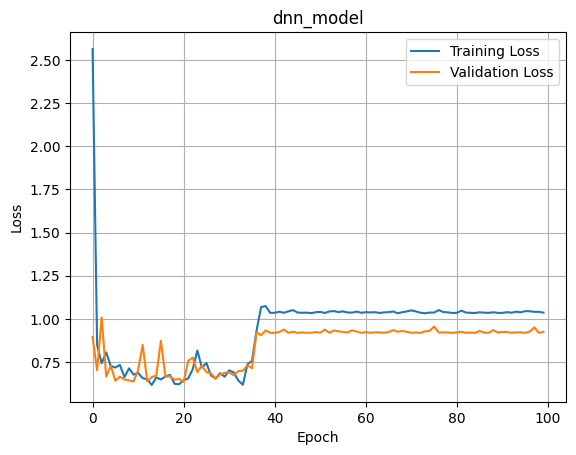

In [636]:
# Display loss plot
plot_loss(history, title="dnn_model")

Learning Rate = 0.1 - Seems to have some overfitting problem based on the overlap and fluctuations of validation_loss check.

Could explore other learning rates and whether they improve training metrics.

In [637]:
# double check using -> evaluate_model function
evaluate_model(dnn_model, X_test, y_test)

16/16 [==============================] - 0s 2ms/step
Mean Absolute Error (MAE): 0.7872086882187556
Mean Squared Error (MSE): 0.9684428223574629
Root Mean Squared Error (RMSE): 0.9840949254810041
---------------------------------------------------------
     Actual  Predicted  Difference
0  0.667346   0.063981   -0.603365
1 -1.176891   0.063981    1.240871
2  0.657377   0.063981   -0.593396
3 -1.077202   0.063981    1.141183
4 -0.130162   0.063981    0.194142
5  1.514698   0.063981   -1.450717
6  1.405041   0.063981   -1.341060
7 -0.229850   0.063981    0.293831
8  0.727159   0.063981   -0.663178
9  0.677315   0.063981   -0.613334
---------------------------------------------------------


(0.7872086882187556, 0.9684428223574629, 0.9840949254810041)

In [638]:
# View count of predictions which were close to actual values
compare_predictions_with_actual(dnn_model, X_test, y_test)

16/16 [==============================] - 0s 2ms/step
Total predicitions: --  511
Number of Predicitions within 0.1: --  44
Number of Predicitions within 0.05: --  19
---------------------------------------------------------
Percentage of predictions within [0.1]: -- 8.61%
Percentage of predictions within [0.05]: -- 3.72%


16/16 [==============================] - 0s 2ms/step


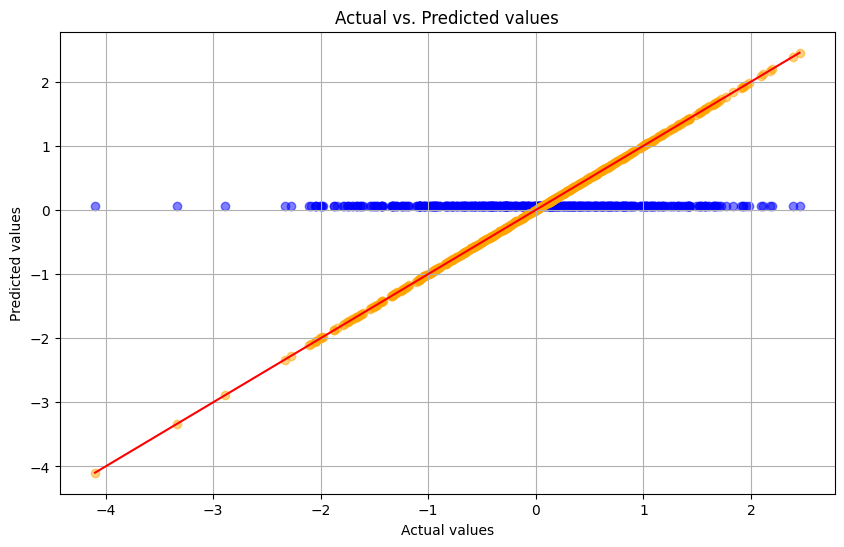

In [639]:
# display plot_predicitions based on X and y test sets
plot_predictions(dnn_model, X_test, y_test)

Less spread compared to the Linear Regression model results.

16/16 [==============================] - 0s 2ms/step


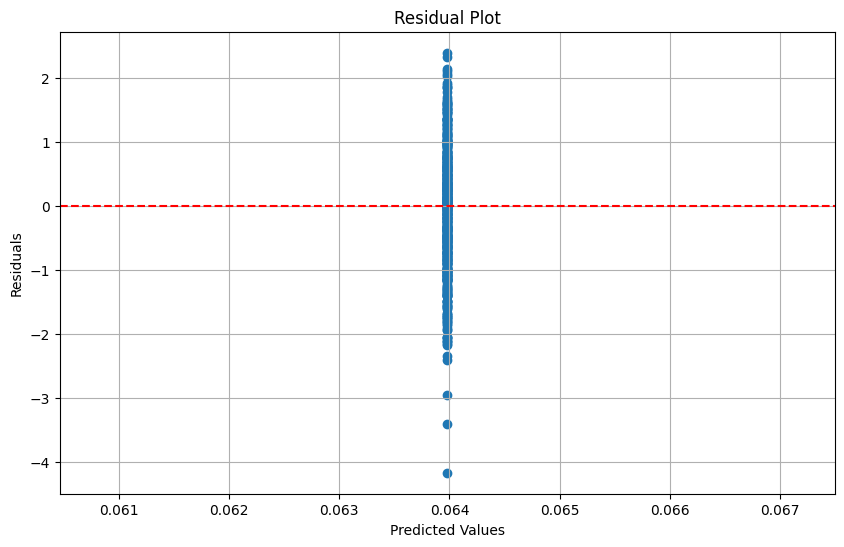

In [640]:
# Plot residuals - distance
plot_residuals(dnn_model, X_test, y_test)

Both plots display very different results compared to all other plots. Whether the learning rate is too high, which caused these results, or another factor affected the lack of variation of predictions in terms of the usual spread. Further testing and models will be constructed to see whether this outcome continues.

## DNN_model2 - LR =0.01

In [641]:
# Building the model2 - LR = 0.01

# include hidden layers (Dense)- activations='relu'
dnn_model2 = tf.keras.Sequential([
    normaliser,
    #hidden layers
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    #output layer
    tf.keras.layers.Dense(1)
])

# View summary
dnn_model2.summary()

# Compiling the model
# adam -> learning rate [default] = 0.001
dnn_model2.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['mean_squared_error'])

# Training the model
# verbose = 0 [does not show the fit process]. changing this to verbose=1 will show the process.
history = dnn_model2.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0)  # Training for 100 epochs

# Evaluating the model
dnn_mse = dnn_model2.evaluate(X_test, y_test)

# Print results
print("Test -- Mean Standard Errors:", dnn_mse)

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_31 (Normaliz  (None, 24)                49        
 ation)                                                          
                                                                 
 dense_142 (Dense)           (None, 64)                1600      
                                                                 
 dense_143 (Dense)           (None, 64)                4160      
                                                                 
 dense_144 (Dense)           (None, 1)                 65        
                                                                 
Total params: 5874 (22.95 KB)
Trainable params: 5825 (22.75 KB)
Non-trainable params: 49 (200.00 Byte)
_________________________________________________________________
16/16 [==============================] - 0s 4ms/step - loss: 0.8345 - mean_squared

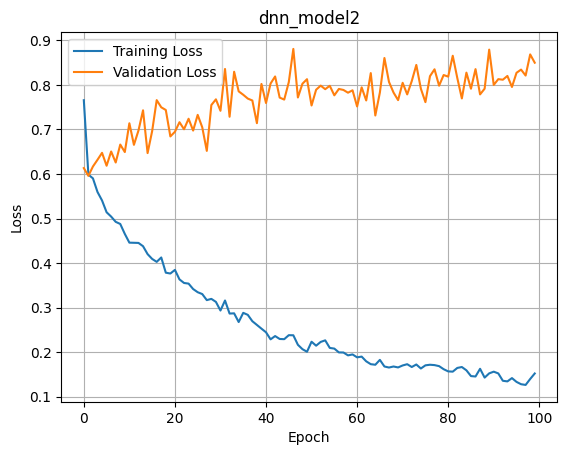

In [642]:
# View plot - loss, val_loss
plot_loss(history, title="dnn_model2")

In [643]:
# double check using -> evaluate_model function
evaluate_model(dnn_model2, X_test, y_test)

16/16 [==============================] - 0s 4ms/step
Mean Absolute Error (MAE): 0.6521365162061468
Mean Squared Error (MSE): 0.8344934630090548
Root Mean Squared Error (RMSE): 0.9135061373680282
---------------------------------------------------------
     Actual  Predicted  Difference
0  0.667346  -0.033188   -0.700534
1 -1.176891   0.068210    1.245101
2  0.657377   0.921998    0.264621
3 -1.077202  -0.115373    0.961829
4 -0.130162  -0.036370    0.093791
5  1.514698   1.020405   -0.494293
6  1.405041   1.488941    0.083901
7 -0.229850  -0.592143   -0.362293
8  0.727159   1.197473    0.470313
9  0.677315   0.480009   -0.197305
---------------------------------------------------------


(0.6521365162061468, 0.8344934630090548, 0.9135061373680282)

In [644]:
# View count of predictions which were close to actual values
compare_predictions_with_actual(dnn_model2, X_test, y_test)

16/16 [==============================] - 0s 2ms/step
Total predicitions: --  511
Number of Predicitions within 0.1: --  64
Number of Predicitions within 0.05: --  32
---------------------------------------------------------
Percentage of predictions within [0.1]: -- 12.52%
Percentage of predictions within [0.05]: -- 6.26%


16/16 [==============================] - 0s 2ms/step


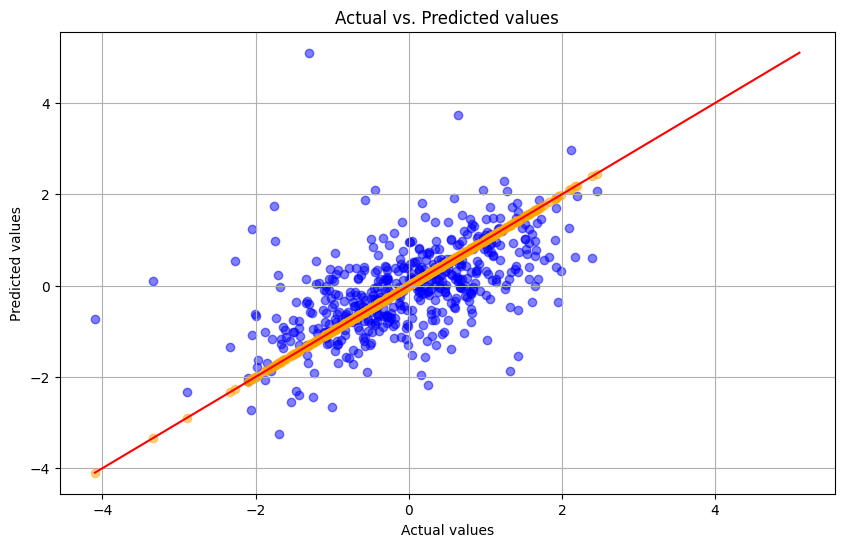

In [645]:
# plot predicitions
plot_predictions(dnn_model2, X_test, y_test)

The predictions tend to follow the linear line. Which indicates better preformance in predictors.

However, there are cases where the predictions are very far off the actual value.

16/16 [==============================] - 0s 2ms/step


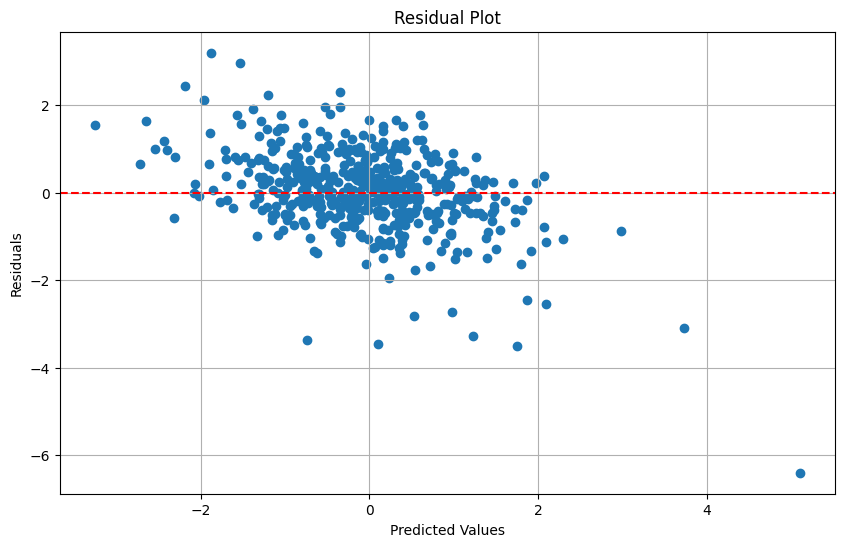

In [646]:
# View residuals - distance
plot_residuals(dnn_model2, X_test, y_test)

## DNN_model3 [version-3] - LR =0.001

In [647]:
# Building the model [3] - LR = 0.001

# include hidden layers (Dense)- activations='relu'
dnn_model3 = tf.keras.Sequential([
    normaliser,
    #hidden layers
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    #output layer
    tf.keras.layers.Dense(1)
])

# View summary
dnn_model3.summary()

# Compiling the model
# adam -> learning rate [default] = 0.001
dnn_model3.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error'])

# Training the model
# verbose = 0 [does not show the fit process]. changing this to verbose=1 will show the process.
history = dnn_model3.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0)  # Training for 100 epochs

# Evaluating the model
dnn_mse = dnn_model3.evaluate(X_test, y_test)

# Print results
print("Test -- Mean Standard Errors:", dnn_mse)

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_31 (Normaliz  (None, 24)                49        
 ation)                                                          
                                                                 
 dense_145 (Dense)           (None, 64)                1600      
                                                                 
 dense_146 (Dense)           (None, 64)                4160      
                                                                 
 dense_147 (Dense)           (None, 1)                 65        
                                                                 
Total params: 5874 (22.95 KB)
Trainable params: 5825 (22.75 KB)
Non-trainable params: 49 (200.00 Byte)
_________________________________________________________________
16/16 [==============================] - 0s 2ms/step - loss: 0.7186 - mean_squared

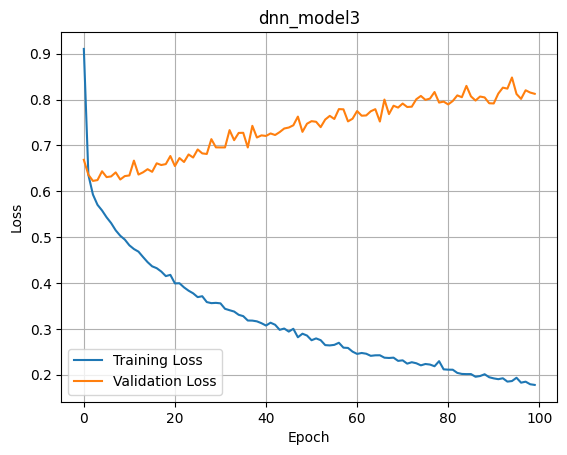

In [648]:
# View plot - loss, val_loss
plot_loss(history, title="dnn_model3")

In [649]:
# double check using -> evaluate_model function
evaluate_model(dnn_model3, X_test, y_test)

16/16 [==============================] - 0s 2ms/step
Mean Absolute Error (MAE): 0.6380938917900536
Mean Squared Error (MSE): 0.7186256189391089
Root Mean Squared Error (RMSE): 0.8477178887690816
---------------------------------------------------------
     Actual  Predicted  Difference
0  0.667346  -0.429376   -1.096722
1 -1.176891  -0.757012    0.419879
2  0.657377   1.863391    1.206013
3 -1.077202  -0.343306    0.733897
4 -0.130162   0.407359    0.537521
5  1.514698   1.335020   -0.179678
6  1.405041   0.336781   -1.068260
7 -0.229850  -0.569663   -0.339813
8  0.727159   0.900088    0.172928
9  0.677315  -1.139150   -1.816465
---------------------------------------------------------


(0.6380938917900536, 0.7186256189391089, 0.8477178887690816)

In [650]:
# View count of predictions which were close to actual values
compare_predictions_with_actual(dnn_model3, X_test, y_test)

16/16 [==============================] - 0s 2ms/step
Total predicitions: --  511
Number of Predicitions within 0.1: --  45
Number of Predicitions within 0.05: --  24
---------------------------------------------------------
Percentage of predictions within [0.1]: -- 8.81%
Percentage of predictions within [0.05]: -- 4.70%


16/16 [==============================] - 0s 2ms/step


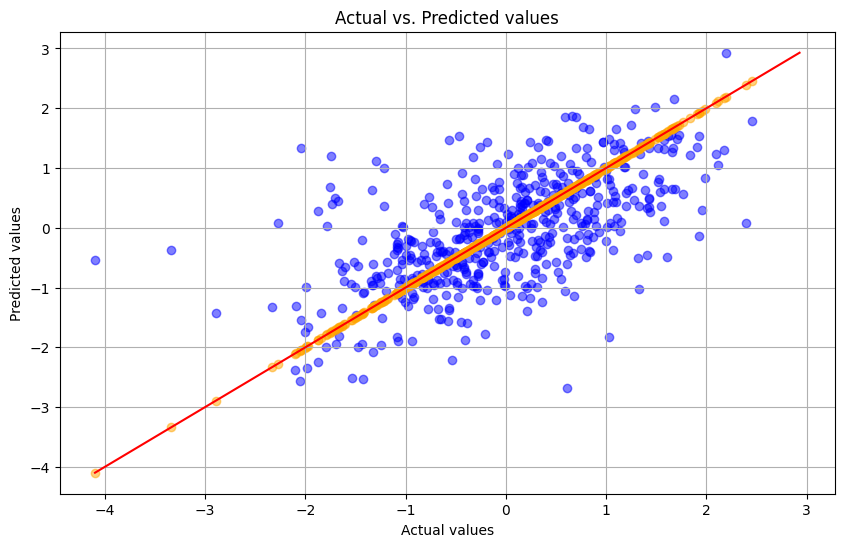

In [651]:
# plot predictions
plot_predictions(dnn_model3, X_test, y_test)

Again, better trend in predictions. With a few cases where the predictions are far of the actual values.

16/16 [==============================] - 0s 2ms/step


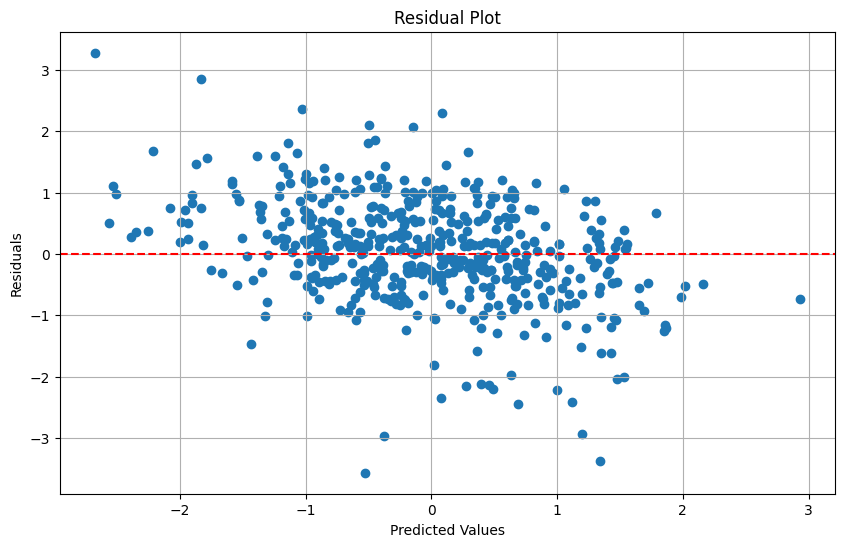

In [652]:
# plot residuals - distance between
plot_residuals(dnn_model3, X_test, y_test)

## DNN Model [Version 2] - Layers

---

Next, this section will test the model based on different hidden layers and the Dense unit applied to each.
In order to perform comprehensive data analysis, I aim to develop a DNN model that delivers the best results.

Previously used: (2 hidden layers, both Dense = 64)

---

I will also determine whether training more epochs results in improved results.

Previously used: (Epochs = 100)

---

Based on Research:

The number of hidden neurons will be between the number of inputs and outputs. In this case, the X_train shape results in 24 inputs, and the output layer looks for one value. Therefore, the dense units will be tested with this range in mind (Sandhya Krishnan, 2021).

In [653]:
# Building the model _version 2 (Dense, Hidden Layers, Epochs)

# include hidden layers (Dense)- activations='relu'
dnn_model_v2 = tf.keras.Sequential([
    normaliser,
    #hidden layers
    tf.keras.layers.Dense(24, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(24, activation='relu'),
    #output layer
    tf.keras.layers.Dense(1)
])

# View summary of DNN model created
dnn_model_v2.summary()

# Compiling the model
# adam -> learning rate [default] = 0.001
dnn_model_v2.compile(optimizer = tf.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mean_squared_error'])

# Training the model
# Verbose = 0 [does not show the fit process].
# Changing this to verbose=1 or 2 (2 being the highest) will show the process.
history = dnn_model_v2.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=2)  # Training for 100 epochs

# Evaluating the model
dnn_mse = dnn_model_v2.evaluate(X_test, y_test)

# Print results
print("Test -- Mean Standard Errors:", dnn_mse)

Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_31 (Normaliz  (None, 24)                49        
 ation)                                                          
                                                                 
 dense_148 (Dense)           (None, 24)                600       
                                                                 
 dense_149 (Dense)           (None, 24)                600       
                                                                 
 dense_150 (Dense)           (None, 1)                 25        
                                                                 
Total params: 1274 (4.98 KB)
Trainable params: 1225 (4.79 KB)
Non-trainable params: 49 (200.00 Byte)
_________________________________________________________________
Epoch 1/100
51/51 - 1s - loss: 1.1467 - mean_squared_error: 1.1467 - val_loss: 0.991

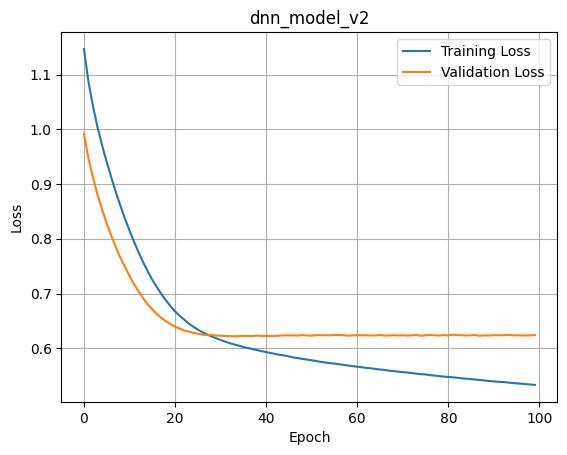

In [654]:
# View plot losses - training
plot_loss(history, title="dnn_model_v2")

In [655]:
# View evaluation results using func ->
evaluate_model(dnn_model_v2, X_test, y_test)

16/16 [==============================] - 0s 1ms/step
Mean Absolute Error (MAE): 0.5582772402035748
Mean Squared Error (MSE): 0.5505303461934642
Root Mean Squared Error (RMSE): 0.7419773218862313
---------------------------------------------------------
     Actual  Predicted  Difference
0  0.667346   0.495610   -0.171736
1 -1.176891  -0.487578    0.689312
2  0.657377   1.040326    0.382949
3 -1.077202  -0.803835    0.273367
4 -0.130162  -0.045165    0.084997
5  1.514698   1.021968   -0.492730
6  1.405041   0.510677   -0.894364
7 -0.229850  -0.463063   -0.233213
8  0.727159   0.446321   -0.280838
9  0.677315   0.138516   -0.538799
---------------------------------------------------------


(0.5582772402035748, 0.5505303461934642, 0.7419773218862313)

In [656]:
# View count of predictions which were close to actual values
compare_predictions_with_actual(dnn_model_v2, X_test, y_test)

16/16 [==============================] - 0s 2ms/step
Total predicitions: --  511
Number of Predicitions within 0.1: --  63
Number of Predicitions within 0.05: --  31
---------------------------------------------------------
Percentage of predictions within [0.1]: -- 12.33%
Percentage of predictions within [0.05]: -- 6.07%


16/16 [==============================] - 0s 1ms/step


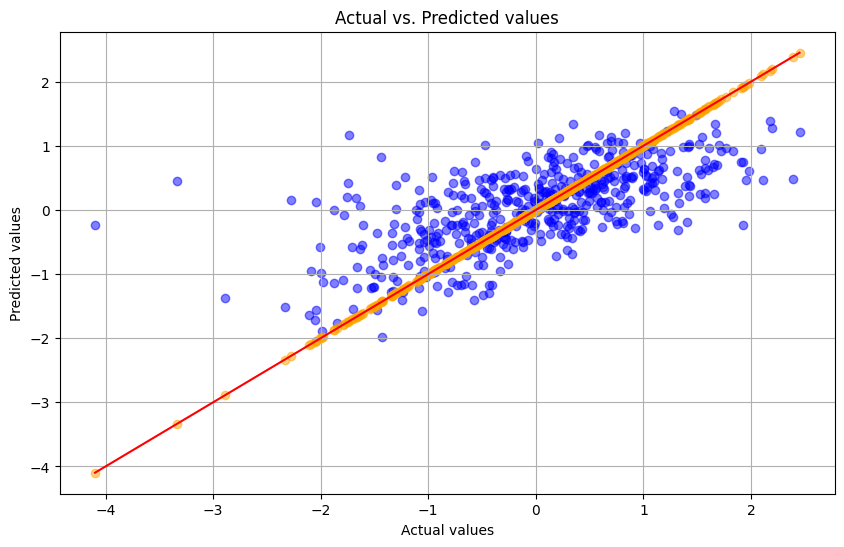

In [657]:
# plot predictions
plot_predictions(dnn_model_v2, X_test, y_test)

16/16 [==============================] - 0s 1ms/step


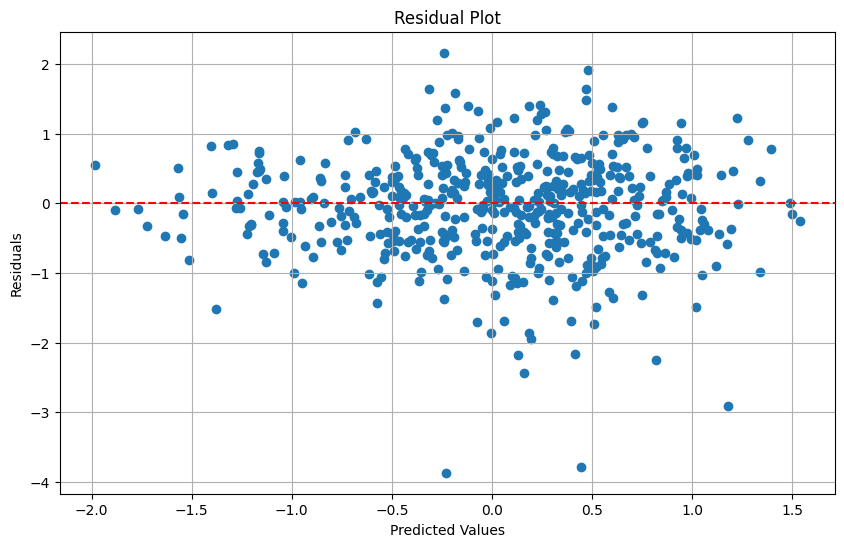

In [658]:
# plot residuals - distance between
plot_residuals(dnn_model_v2, X_test, y_test)

In [659]:
# Building the model _version 3  (Dense, Hidden Layers, Epochs)
# Next test --

# include hidden layers (Dense)- activations='relu'
dnn_model_v3 = tf.keras.Sequential([
    normaliser,
    #hidden layers
    tf.keras.layers.Dense(24, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    #output layer
    tf.keras.layers.Dense(1)
])

# View summary of DNN model created
dnn_model_v3.summary()

# Compiling the model
# adam -> learning rate [default] = 0.001
dnn_model_v3.compile(optimizer = tf.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mean_squared_error'])

# Training the model
# Verbose = 0 [does not show the fit process].
# Changing this to verbose=1 or 2 (2 being the highest) will show the process.
history = dnn_model_v3.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=2)  # Training for 100 epochs

# Evaluating the model
dnn_mse = dnn_model_v2.evaluate(X_test, y_test)

# Print results
print("Test -- Mean Standard Errors:", dnn_mse)

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_31 (Normaliz  (None, 24)                49        
 ation)                                                          
                                                                 
 dense_151 (Dense)           (None, 24)                600       
                                                                 
 dense_152 (Dense)           (None, 16)                400       
                                                                 
 dense_153 (Dense)           (None, 8)                 136       
                                                                 
 dense_154 (Dense)           (None, 1)                 9         
                                                                 
Total params: 1194 (4.67 KB)
Trainable params: 1145 (4.47 KB)
Non-trainable params: 49 (200.00 Byte)
__________________

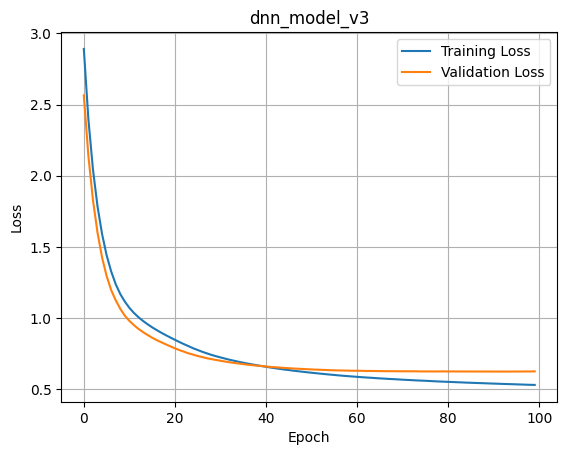

In [660]:
# View plot losses - training
plot_loss(history, title="dnn_model_v3")

In [661]:
# View evaluation results using func ->
evaluate_model(dnn_model_v3, X_test, y_test)

16/16 [==============================] - 0s 2ms/step
Mean Absolute Error (MAE): 0.5450649904446762
Mean Squared Error (MSE): 0.533597098500514
Root Mean Squared Error (RMSE): 0.7304773086828323
---------------------------------------------------------
     Actual  Predicted  Difference
0  0.667346   0.474483   -0.192863
1 -1.176891  -0.553956    0.622934
2  0.657377   1.201423    0.544046
3 -1.077202  -0.727259    0.349943
4 -0.130162  -0.103804    0.026358
5  1.514698   0.845420   -0.669278
6  1.405041   0.474138   -0.930903
7 -0.229850  -0.343778   -0.113928
8  0.727159   0.424228   -0.302931
9  0.677315  -0.388426   -1.065741
---------------------------------------------------------


(0.5450649904446762, 0.533597098500514, 0.7304773086828323)

In [662]:
# View count of predictions which were close to actual values
compare_predictions_with_actual(dnn_model_v3, X_test, y_test)

16/16 [==============================] - 0s 2ms/step
Total predicitions: --  511
Number of Predicitions within 0.1: --  76
Number of Predicitions within 0.05: --  48
---------------------------------------------------------
Percentage of predictions within [0.1]: -- 14.87%
Percentage of predictions within [0.05]: -- 9.39%


16/16 [==============================] - 0s 2ms/step


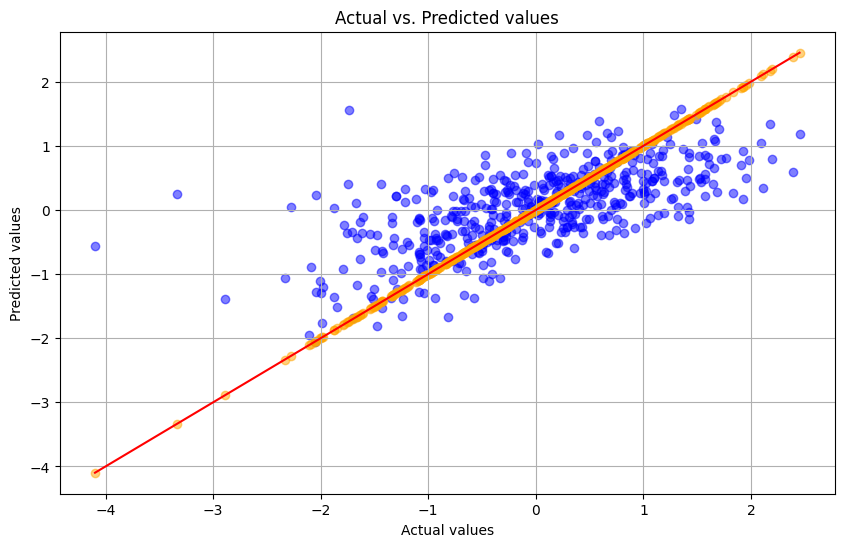

In [663]:
# plot predictions
plot_predictions(dnn_model_v3, X_test, y_test)

16/16 [==============================] - 0s 2ms/step


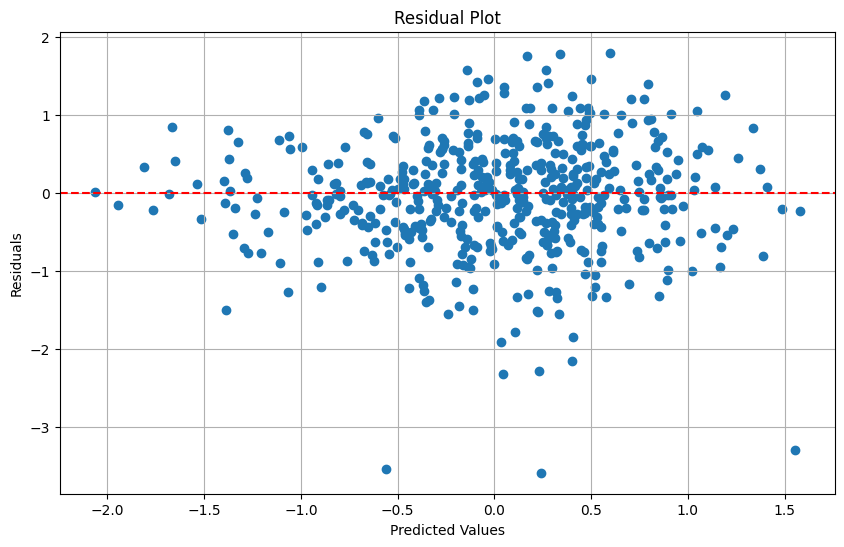

In [664]:
# plot residuals - distance between
plot_residuals(dnn_model_v3, X_test, y_test)

# Overview - DNN Models

---

## **plot_predicitions:**

There was a trend with all plots, which had difficulty predicting the target value when the value was negative, with a couple of results around -3 and -4 (standardised NUM_COLLISIONS).

Where -4 was the actual value, the predictions would fluctuate between -1 and 1. This might be due to the obscurity of this value compared to the others, where a majority tended to be between -2 and 2 (actual values).

When the actual value was higher in the positive range (2+), the prediction tended to drift lower than its actual value. As a result, the models did not perform well overall due to these extreme edge cases.

---

## **evaluations:**

---

### Loss Metrics (mae, mse, rmse)

dnn_model:
- Mean Absolute Error (MAE): 0.7085096139851338
- Mean Squared Error (MSE): 0.8133121032982427
- Root Mean Squared Error (RMSE): 0.9018381802176278

dnn_model2
- Mean Absolute Error (MAE): 0.6415483557372919
- Mean Squared Error (MSE): 0.7687262866902085
- Root Mean Squared Error (RMSE): 0.8767703728401232

dnn_model3
- Mean Absolute Error (MAE): 0.6385247017564869
- Mean Squared Error (MSE): 0.6944034520543217
- Root Mean Squared Error (RMSE): 0.8333087375362878

dnn_model_v2
- Mean Absolute Error (MAE): 0.5554415445328899
- Mean Squared Error (MSE): 0.5631518429154061
- Root Mean Squared Error (RMSE): 0.7504344361204422

dnn_model_v3
- Mean Absolute Error (MAE): 0.5435130035309383
- Mean Squared Error (MSE): 0.5311519487397478
- Root Mean Squared Error (RMSE): 0.7288017211421415

---

**Best Loss Metrics:**

dnn_model_v3 -- Mean Absolute Error (MAE): 0.5435130035309383

dnn_model_v3 -- Mean Squared Error (MSE): 0.5311519487397478

dnn_model_v3 -- Root Mean Squared Error (RMSE): 0.7288017211421415

---

### Percentages (0.1 and 0.05)

dnn_model:
- Percentage of predictions within [0.1]: -- 9.00%
- Percentage of predictions within [0.05]: -- 4.50%

dnn_model2
- Percentage of predictions within [0.1]: -- 10.37%
- Percentage of predictions within [0.05]: -- 3.72%

dnn_model3
- Percentage of predictions within [0.1]: -- 10.37%
- Percentage of predictions within [0.05]: -- 5.09%

dnn_model_v2
- Percentage of predictions within [0.1]: -- 14.29%
- Percentage of predictions within [0.05]: -- 7.83%

dnn_model_v3
- Percentage of predictions within [0.1]: -- 14.09%
- Percentage of predictions within [0.05]: -- 7.44%

---

**Best Percentage**

dnn_model_v2 -- Percentage of predictions within [0.1]: -- 14.29%
dnn_model_v2 -- Percentage of predictions within [0.05]: -- 7.83%

Both dnn_model_v2, dnn_model_v3 had very similar percentage score.
Improving by 4% in relation to within 0.1 distance and around 2% improvement within 0.05 range.

---

# Conclusion

Regarding the case study, weather variables, alongside the day, performed relatively poorly in predicting the number of collisions. Despite the varied results, DNN models had the best overall performance. One model predicted an outcome close to the actual value with an accuracy of 14%.

This does not mean testing weather properties against traffic collisions is generally bad. However, it may be difficult to predict based solely on the selected variables in this report.

Other factors may play a more critical role than weather in traffic collisions.

Finally, these results may be due to my inexperience and relatively limited analysis (Evaluation Data Analysis). Better results alongside additional methods and more advanced data analysis techniques could enhance the performance of models and the overall accuracy of collisions based in New York.


[Word count: 1635]

# Resources

freeCodeCamp.org (2022). Machine Learning for Everybody – Full Course. YouTube. Available at: https://www.youtube.com/watch?v=i_LwzRVP7bg [Accessed 20 Apr. 2024].

# References

---

Benton, J. (2020). Interpreting Coefficients in Linear and Logistic Regression. [online] Medium. Available at: https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1 [Accessed 23 Apr. 2024].

---

Bobbitt, Z. (2021). How to Interpret the Intercept in a Regression Model (With Examples). [online] Statology. Available at: https://www.statology.org/intercept-in-regression/ [Accessed 23 Apr. 2024].

---

Chugh, V. (2022). Tuning Adam Optimizer Parameters in PyTorch. [online] KDnuggets. Available at: https://www.kdnuggets.com/2022/12/tuning-adam-optimizer-parameters-pytorch.html [Accessed 23 Apr. 2024].

---

IBM (2024). R2. [online] www.ibm.com. Available at: https://www.ibm.com/docs/en/cognos-analytics/11.1.0?topic=terms-r2 [Accessed 23 Apr. 2024].

---

Sandhya Krishnan (2021). How to Determine the Number of Layers and Neurons in the Hidden layer? [online] Medium. Available at: https://medium.com/geekculture/introduction-to-neural-network-2f8b8221fbd3 [Accessed 23 Apr. 2024].

---